In [1]:
import os
os.chdir("../")
# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

from config import *
from data import *
from train import *
from eval import *
from generation import *
from vital2d import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [2]:

overwrite = False
model_name = 'test_mixture13' 


text1 = ('The time series exhibits a upward linear trend.',2)
text2 = ('The time series exhibits a seasonal pattern.',1)
text3 = ('The mean of the time series shifts over time.',5)
counter_text1 = ('The time series exhibits a downward linear trend.',2)
counter_text2 = ('No seasonal pattern.',1)
counter_text3 = ('No sharp shifts.',1)

text_config = {'text_pairs': [[text1, counter_text1],
                              # [text2, counter_text2],
                            [text3, counter_text3]
                ],  'n': None}


update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'segment2',
    y_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    y_pred_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    # y_levels = ['The time series exhibits a seasonal pattern.', 'No seasonal pattern.'],
    # y_pred_levels = ['The time series exhibits a seasonal pattern.', 'No seasonal pattern.'],
    # txt2ts
    txt2ts_y_cols = ['segment1', 'segment2'],
    
    
    # Data settings
    text_col = 'text', #'ts_description',
    seq_length = 200,
    downsample = True,
    downsample_size = 10000,
    downsample_levels = ['The mean of the time series shifts over time.', 'No sharp shifts.'],
    # downsample_levels = ['The time series exhibits a seasonal pattern.', 'No seasonal pattern.'],
    custom_target_cols = ['segment1', 'segment2', 'label'], # 'label' is the same as the default "by_label" target
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = True,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 100,
    alpha = 1/100,
    num_saves = 10,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()


# Data

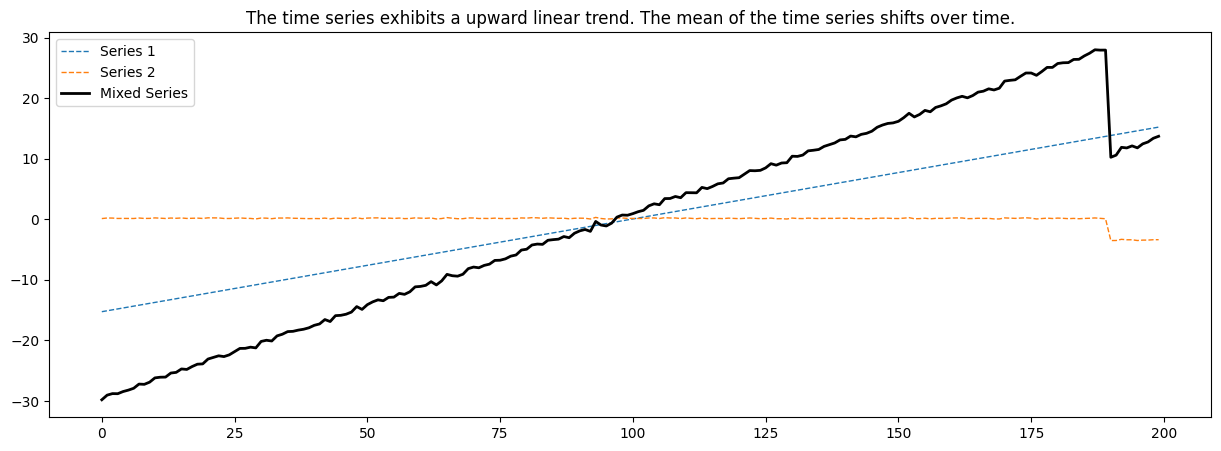

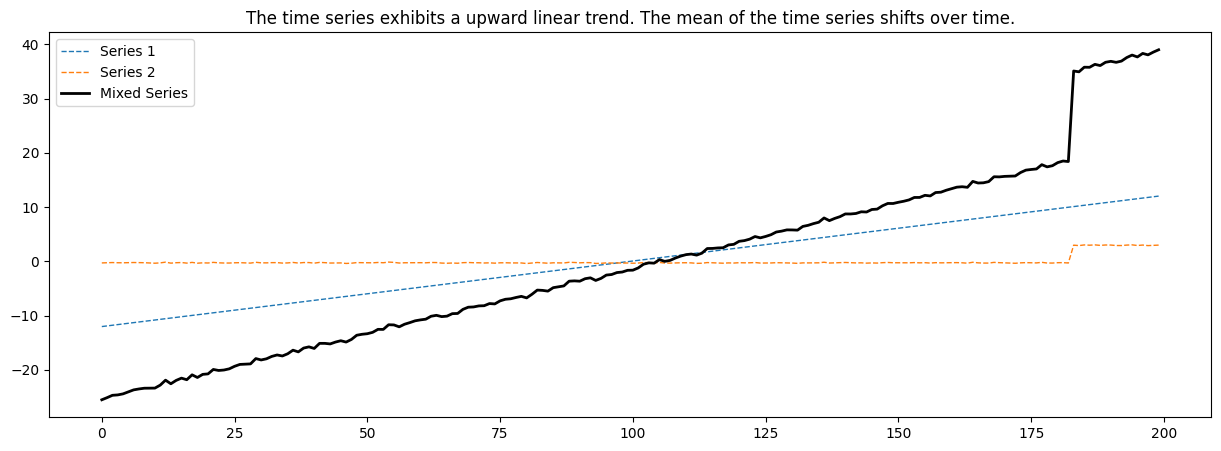

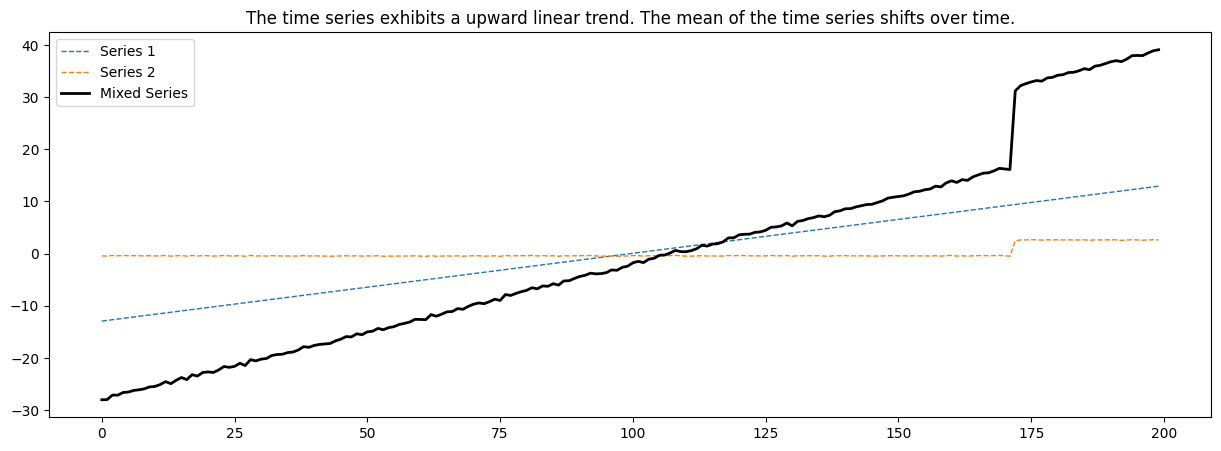

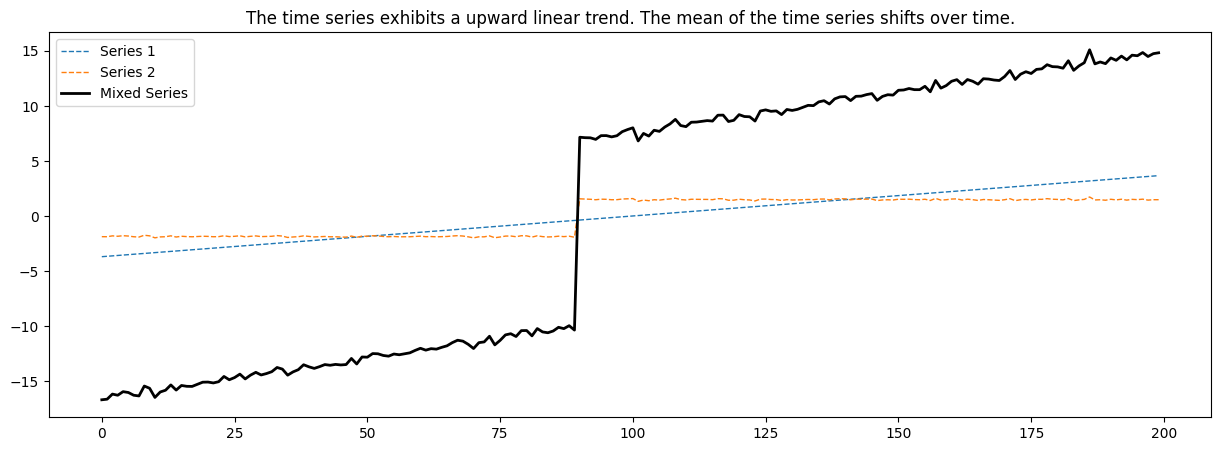

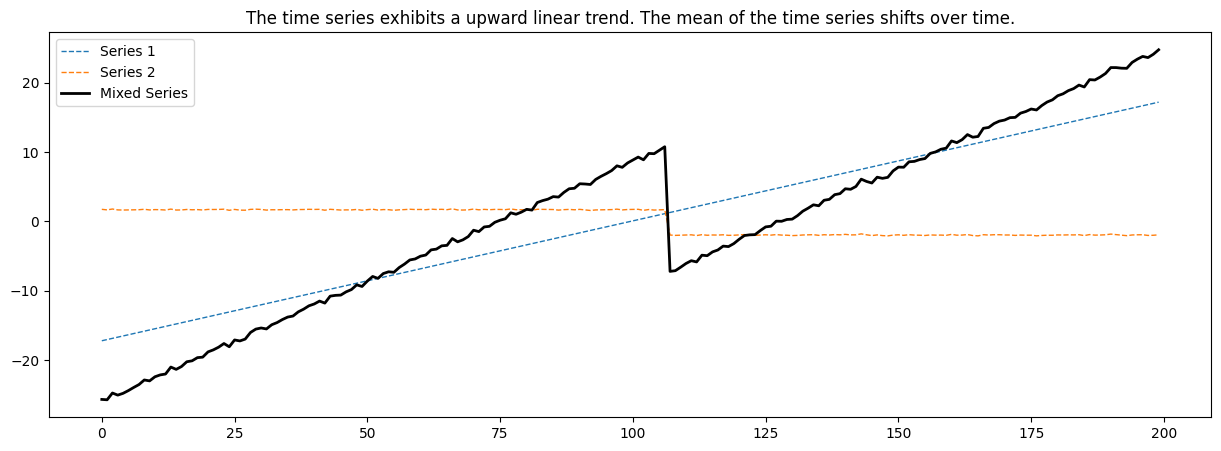

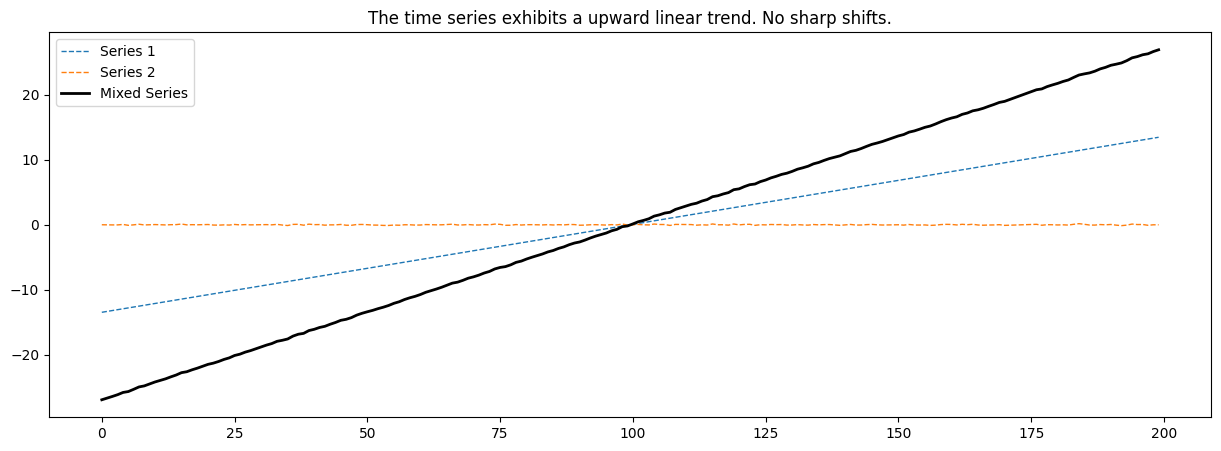

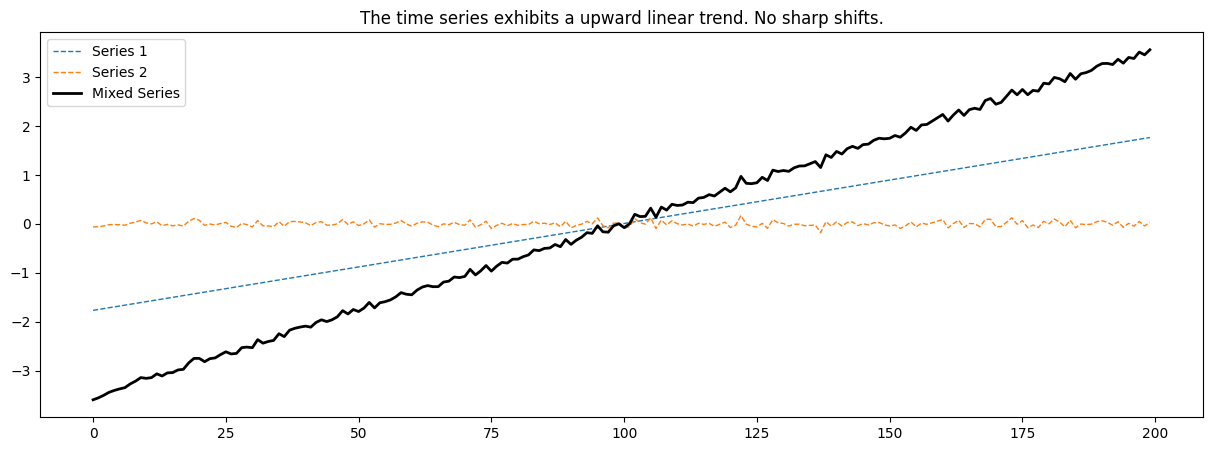

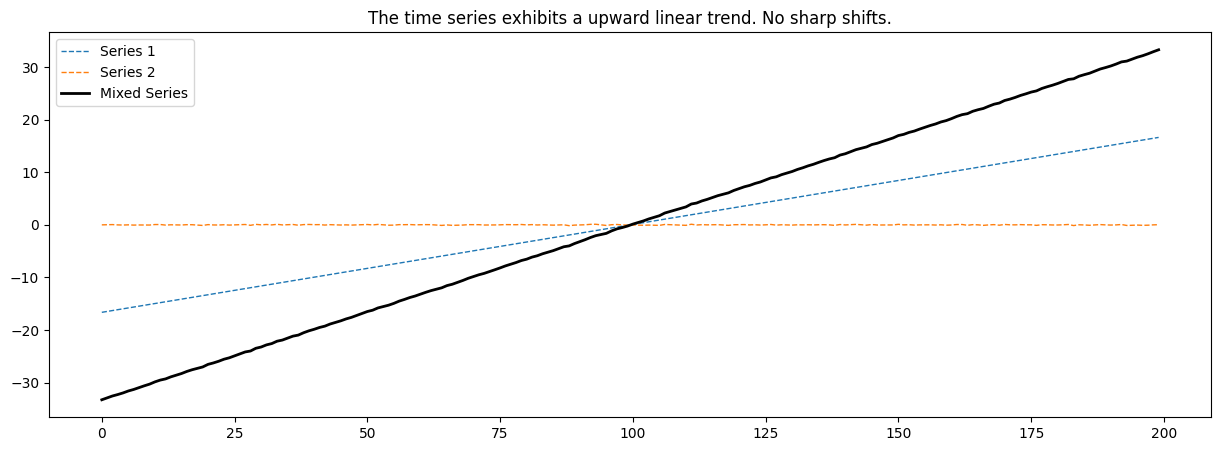

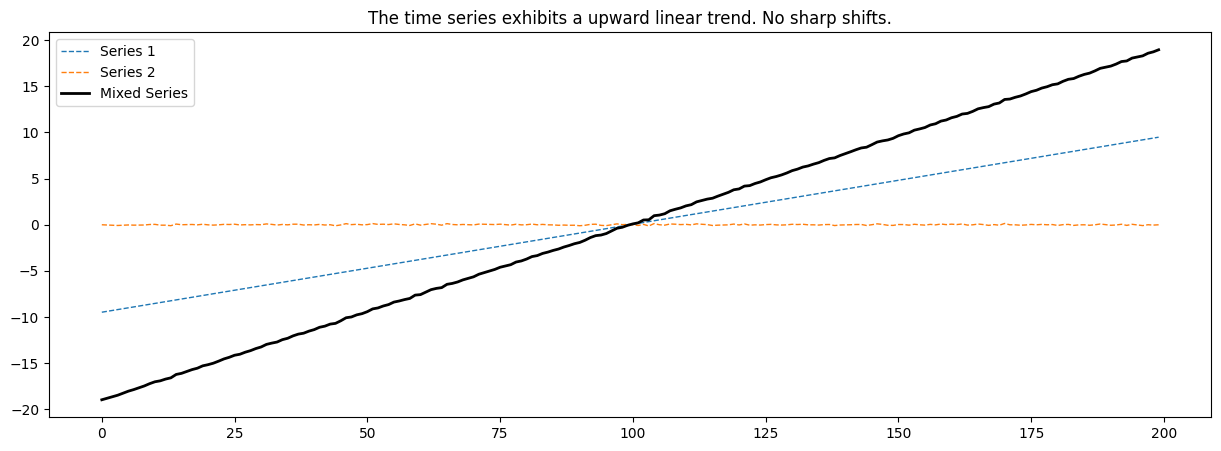

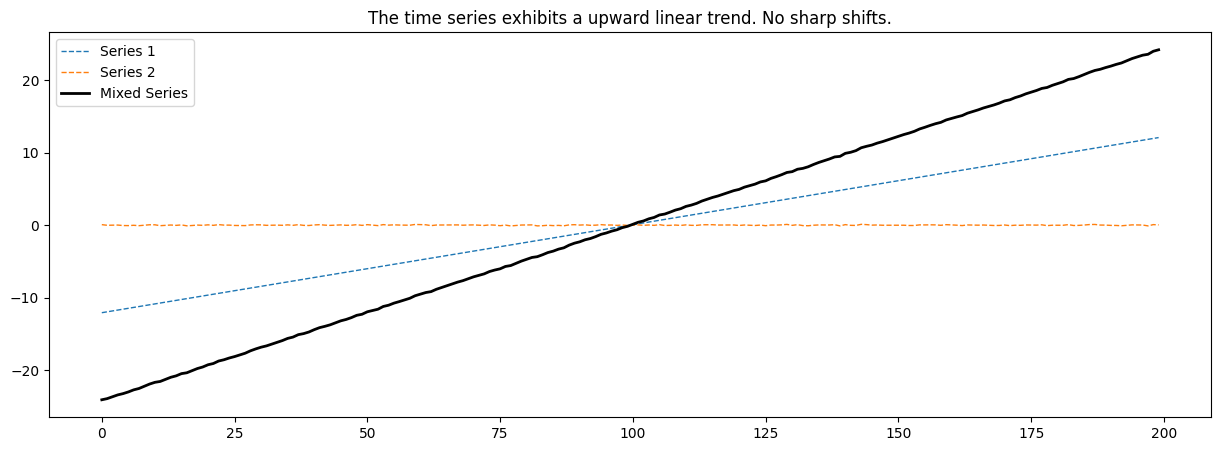

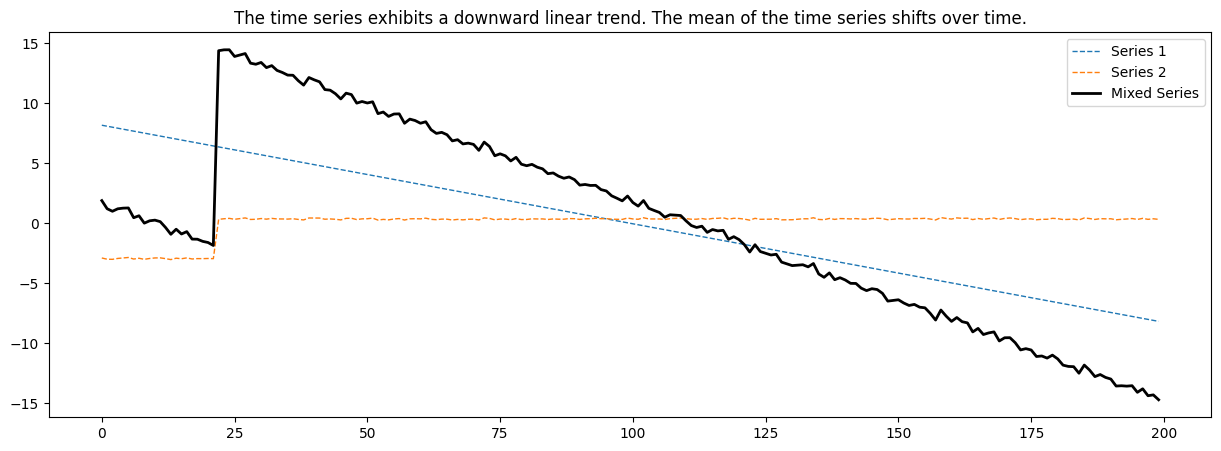

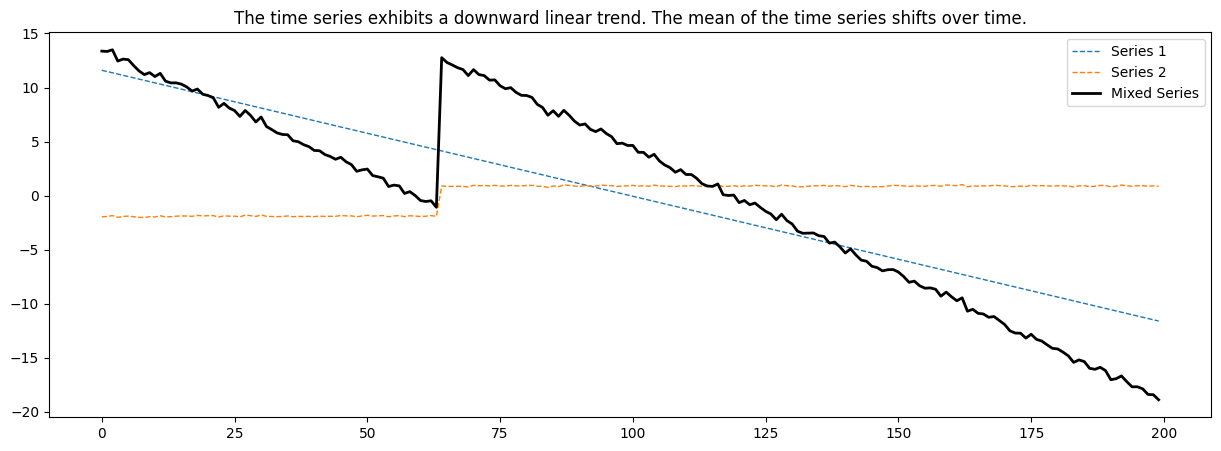

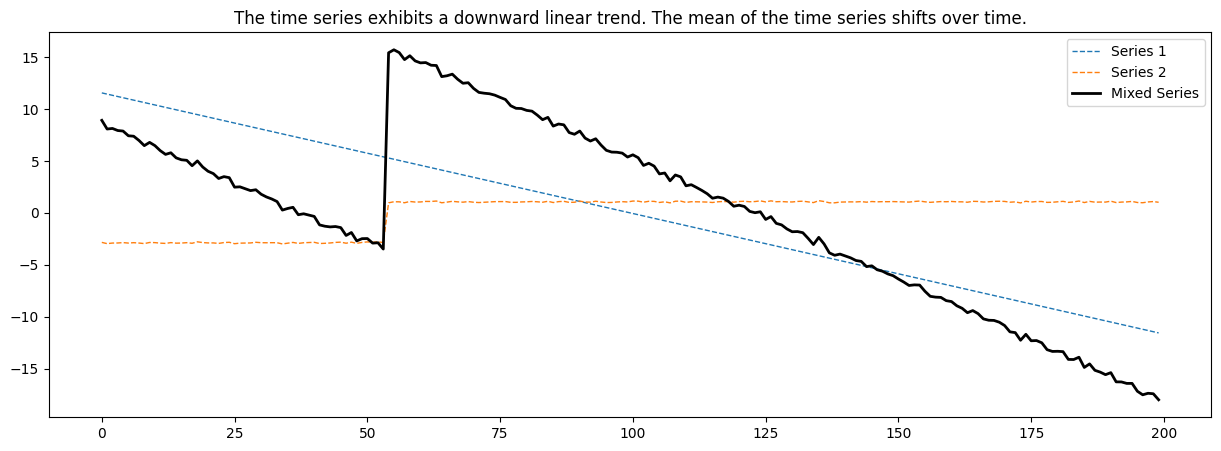

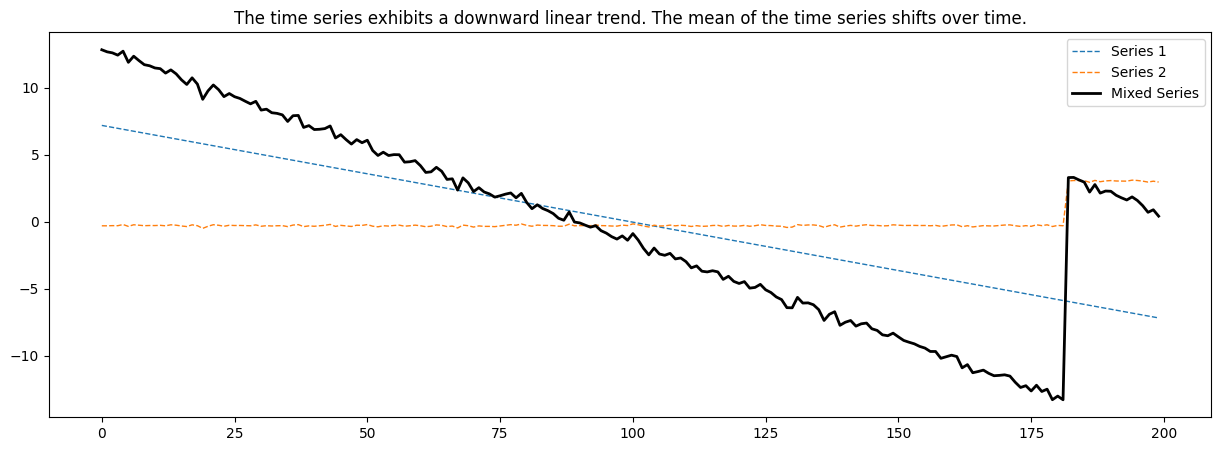

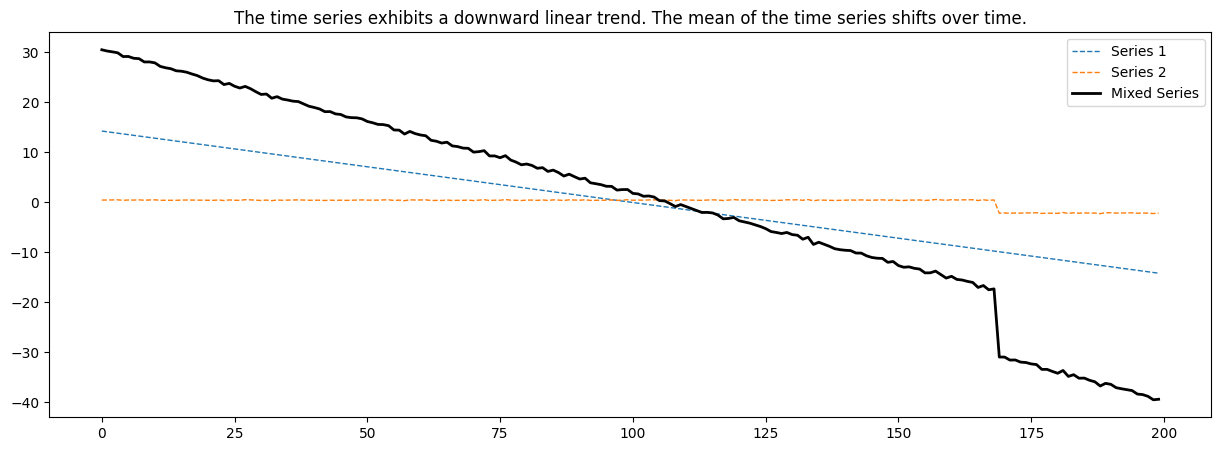

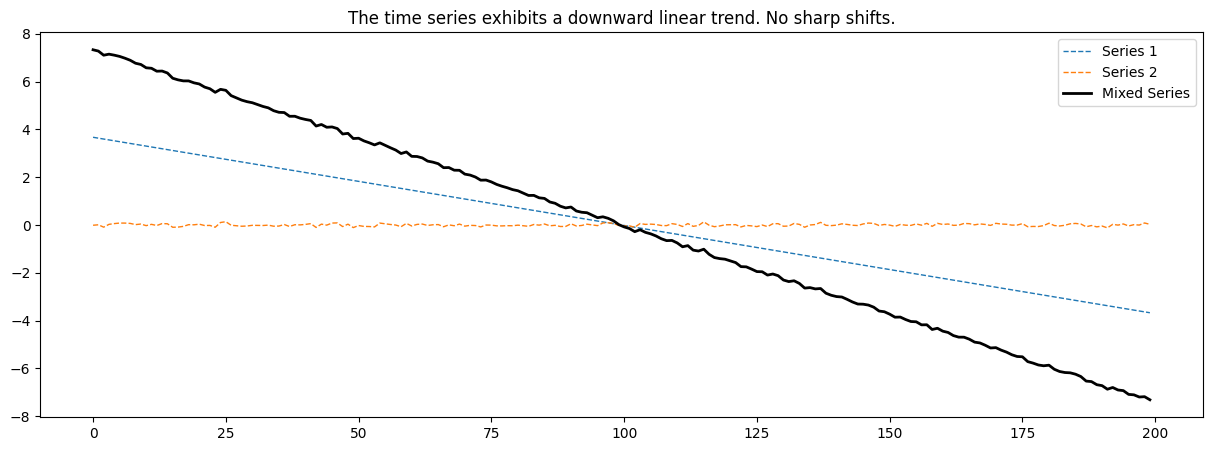

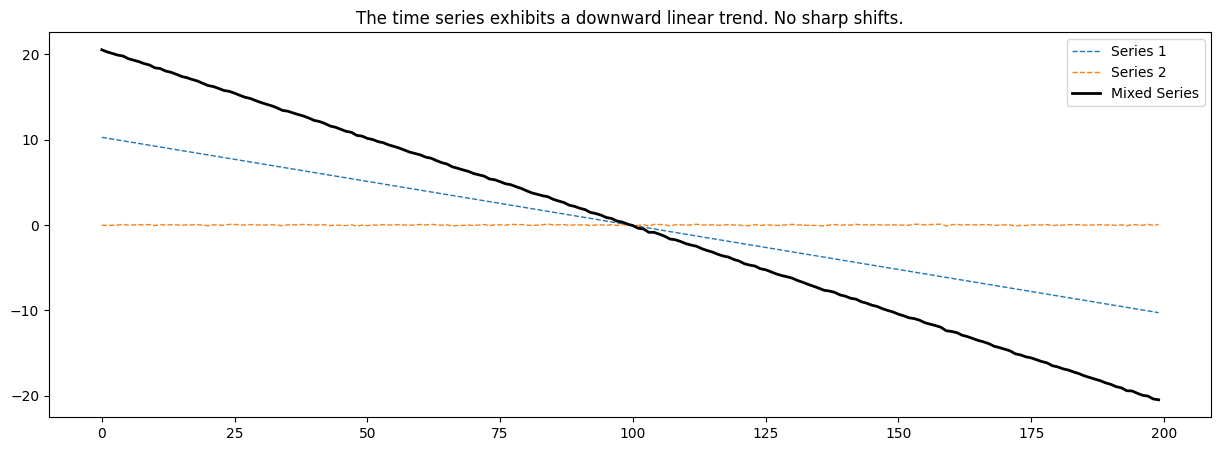

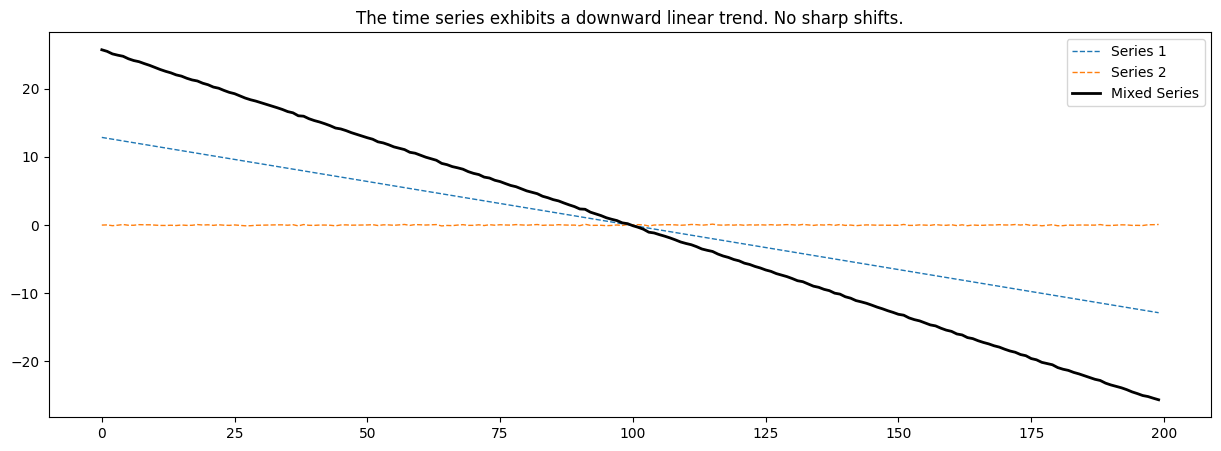

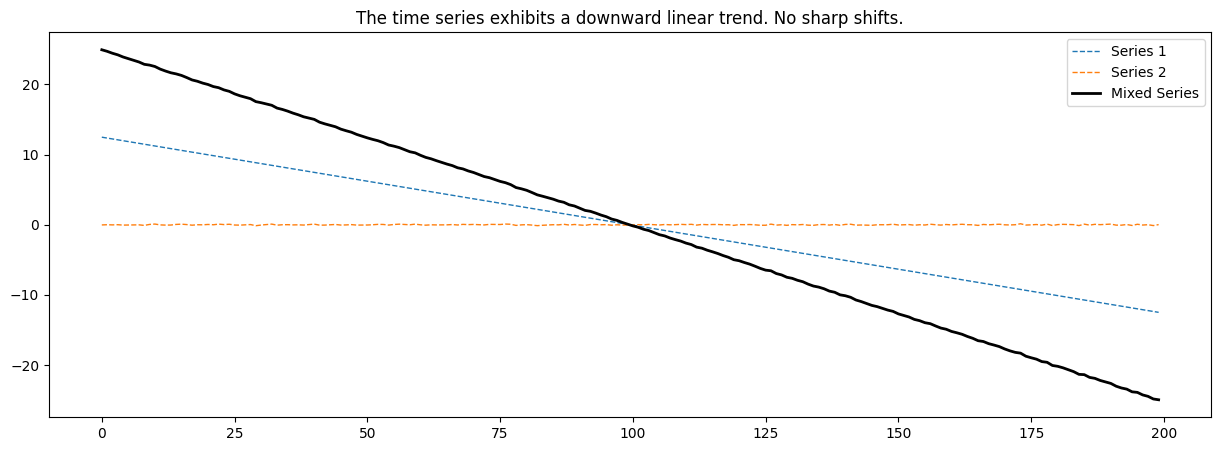

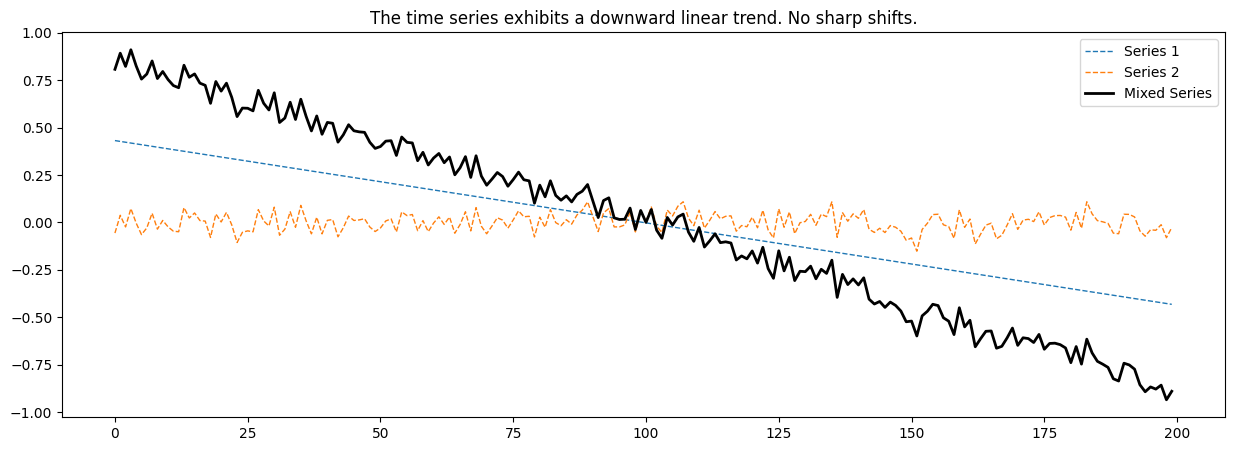

text
The time series exhibits a upward linear trend. The mean of the time series shifts over time.      10000
The time series exhibits a upward linear trend. No sharp shifts.                                   10000
The time series exhibits a downward linear trend. The mean of the time series shifts over time.    10000
The time series exhibits a downward linear trend. No sharp shifts.                                 10000
Name: count, dtype: int64
After downsampling:
segment2
The mean of the time series shifts over time.    10000
No sharp shifts.                                 10000
Name: count, dtype: int64
After downsampling:
segment2
The mean of the time series shifts over time.    4000
No sharp shifts.                                 4000
Name: count, dtype: int64


final distribution of text prediction
text
The time series exhibits a downward linear trend. No sharp shifts.                                 5043
The time series exhibits a downward linear trend. The mean of the time s

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# change data preparation for a given experiment
with open('prepare_experiment/synthetic.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())

# Model (customizable)

In [4]:
# customize encoder and decoder here. 
ts_encoder = CNNEncoder(ts_dim = ts_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[16], kernel_size=50, dropout=0)
ts_decoder = None # default decoder
text_encoder = TextEncoderCNN(text_dim = tx_f_dim.shape[1], output_dim=config_dict['embedded_dim'], num_channels=[16], kernel_size=50, dropout=0)
# overwrite = False
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                   Param #
VITAL                                    1
├─TSVAEEncoder: 1-1                      --
│    └─LocalNorm: 2-1                    --
│    └─CNNEncoder: 2-2                   --
│    │    └─Sequential: 3-1              820,560
│    └─Linear: 2-3                       262,656
│    └─Linear: 2-4                       262,656
├─TextEncoder: 1-2                       --
│    └─TextEncoderCNN: 2-5               --
│    │    └─Sequential: 3-2              3,147,088
├─TSVAEDecoder: 1-3                      --
│    └─Sequential: 2-6                   --
│    │    └─Linear: 3-3                  131,328
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  65,792
│    │    └─LeakyReLU: 3-6               --
│    │    └─Linear: 3-7                  51,400
Total params: 4,741,481
Trainable params: 4,741,481
Non-trainable params: 0


# Train

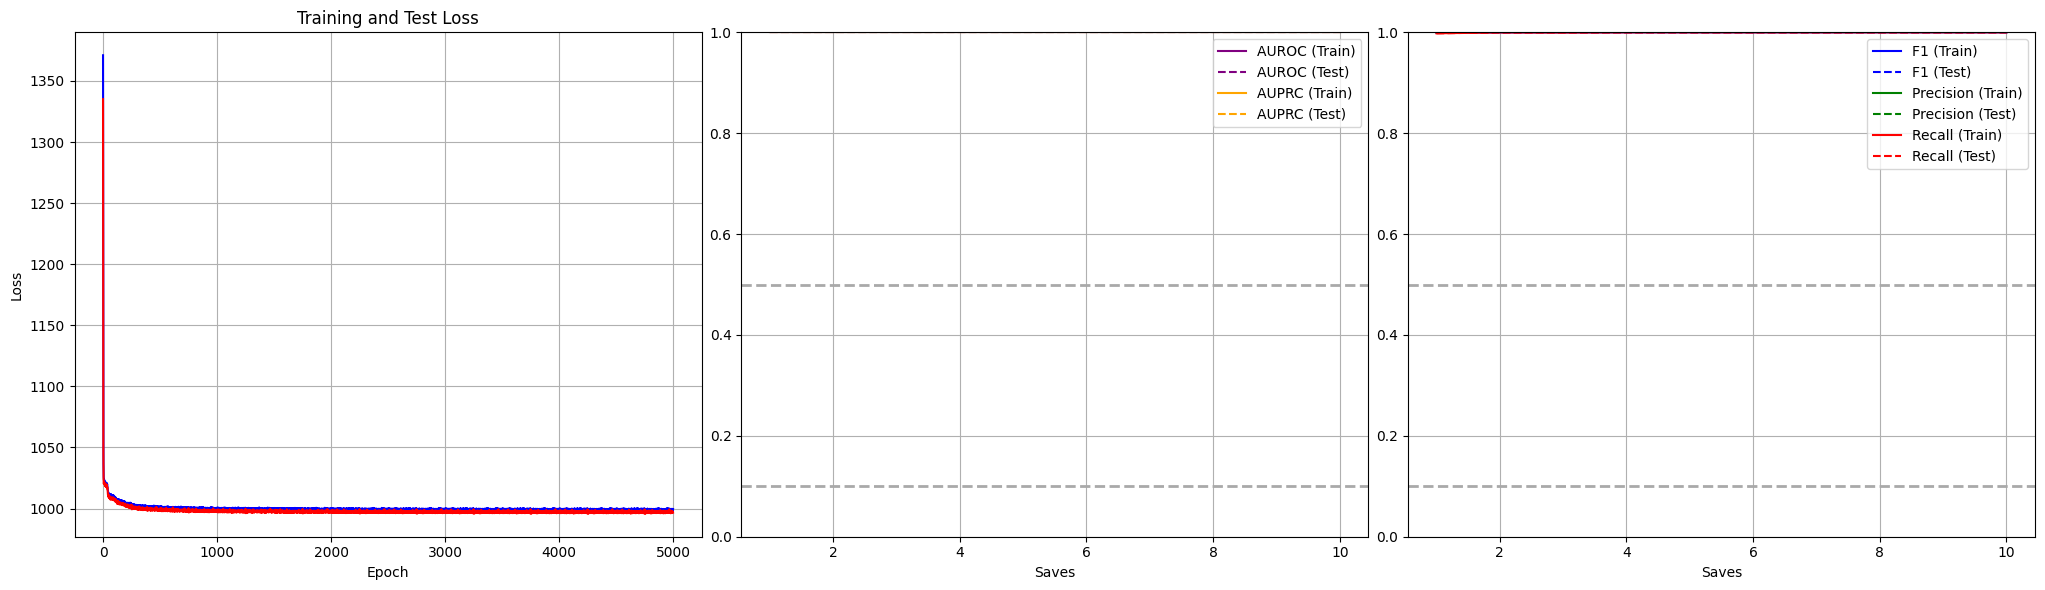

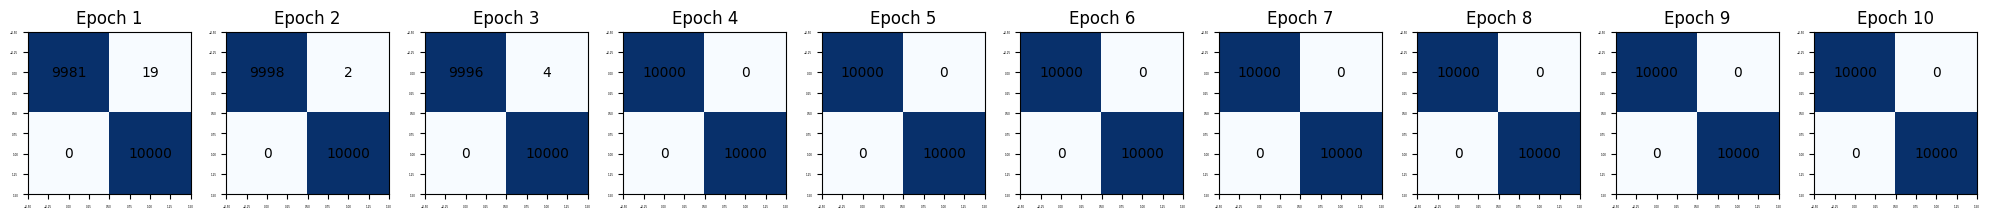

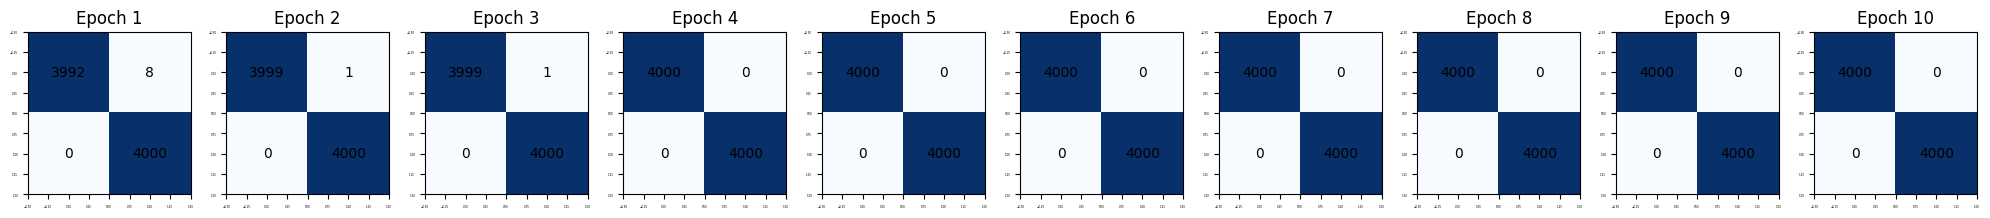

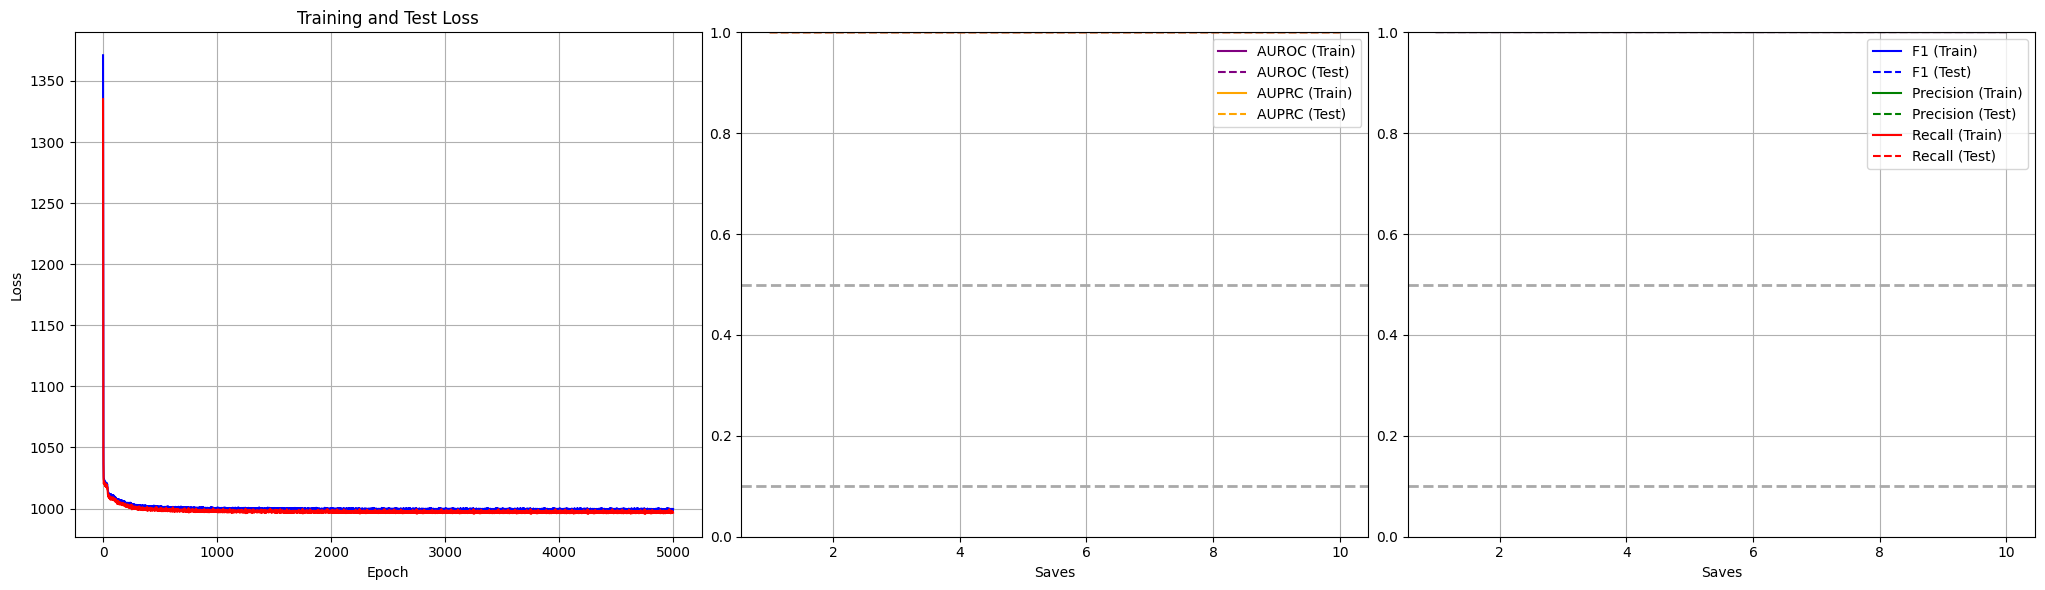

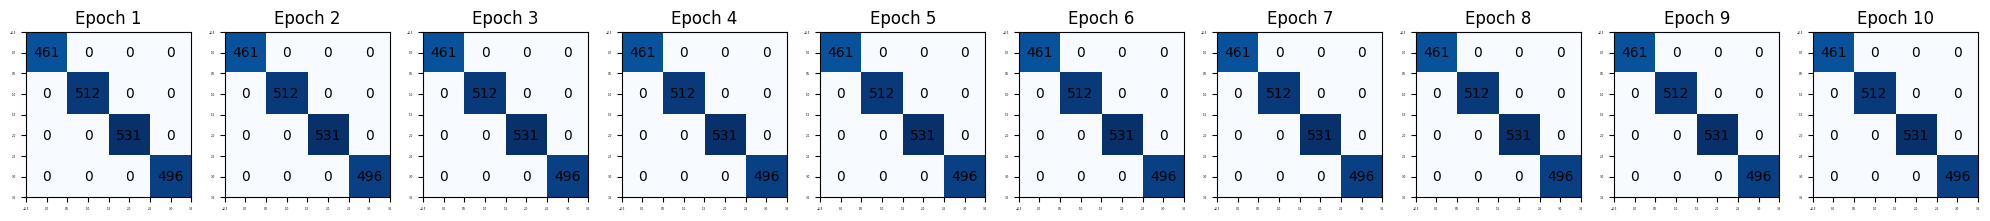

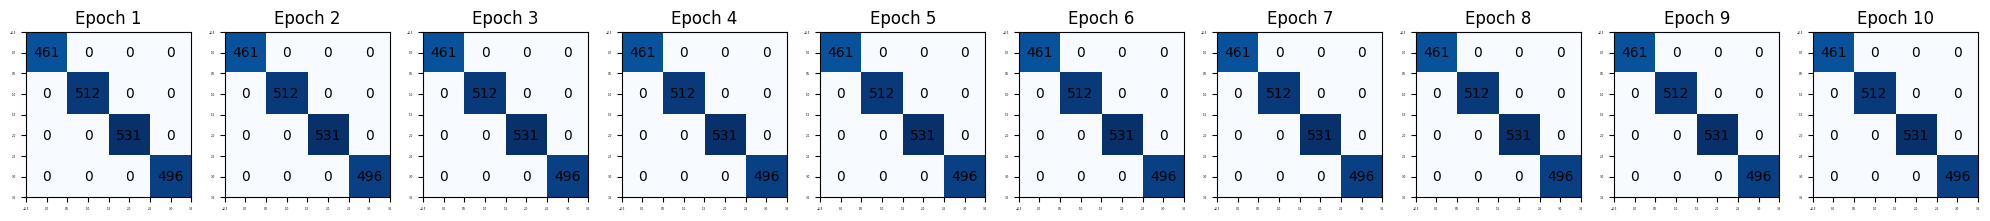

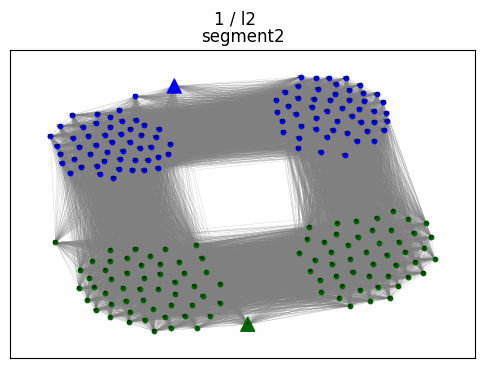

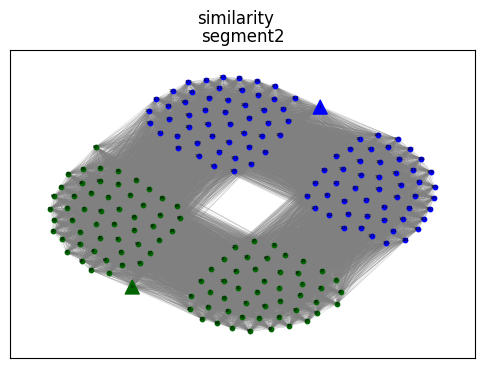

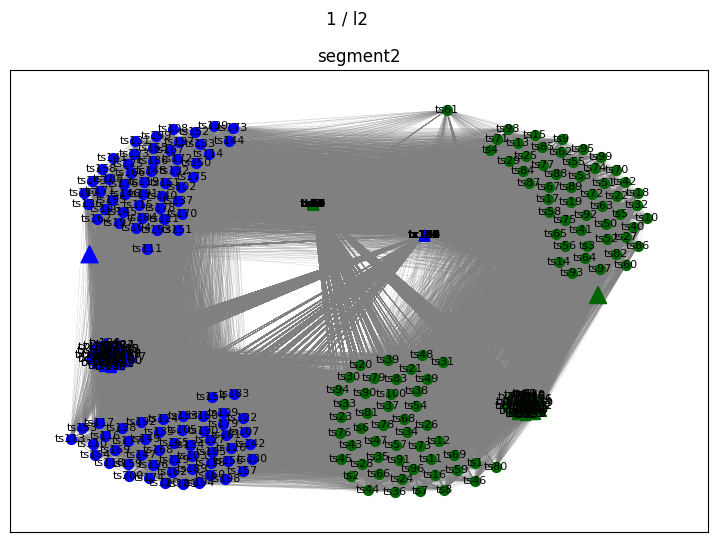

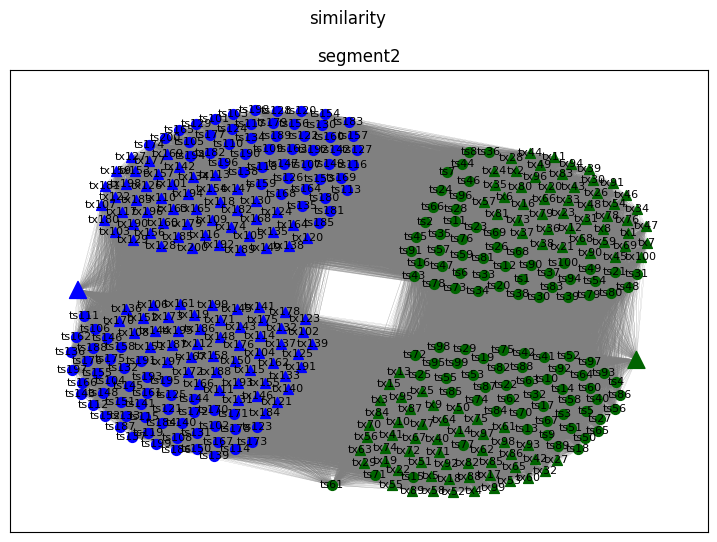

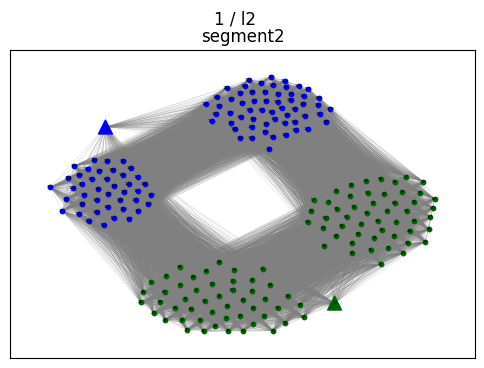

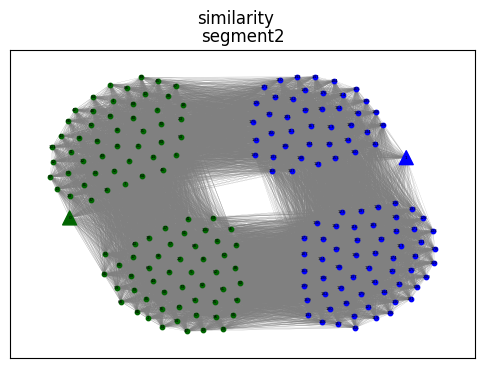

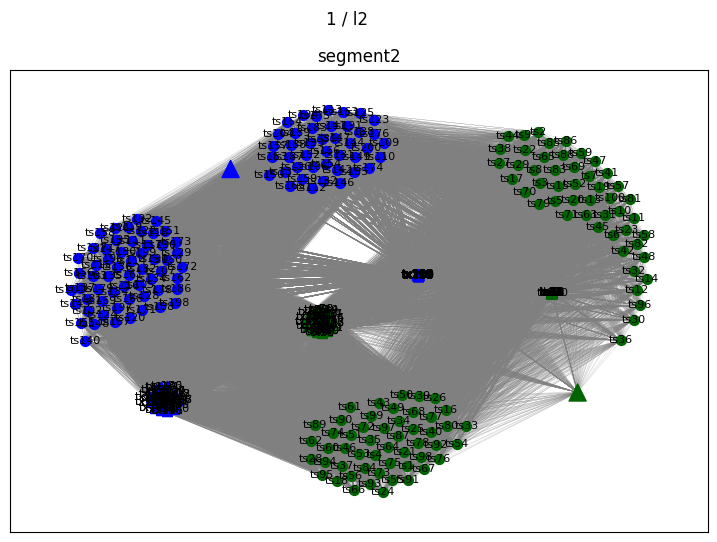

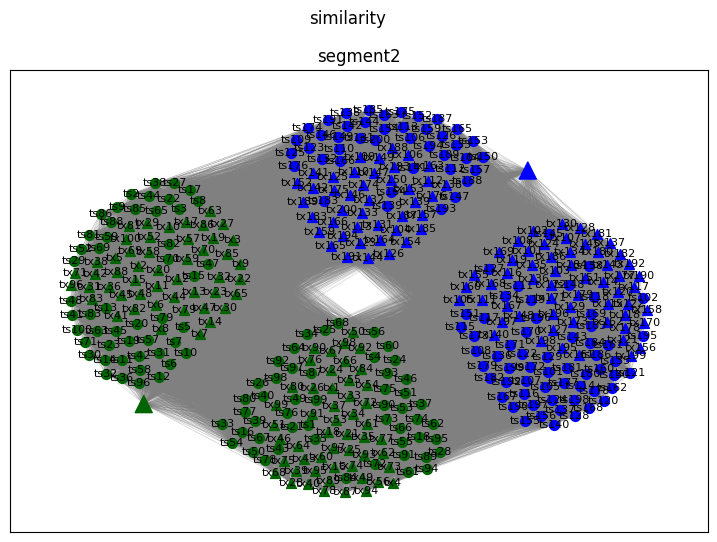

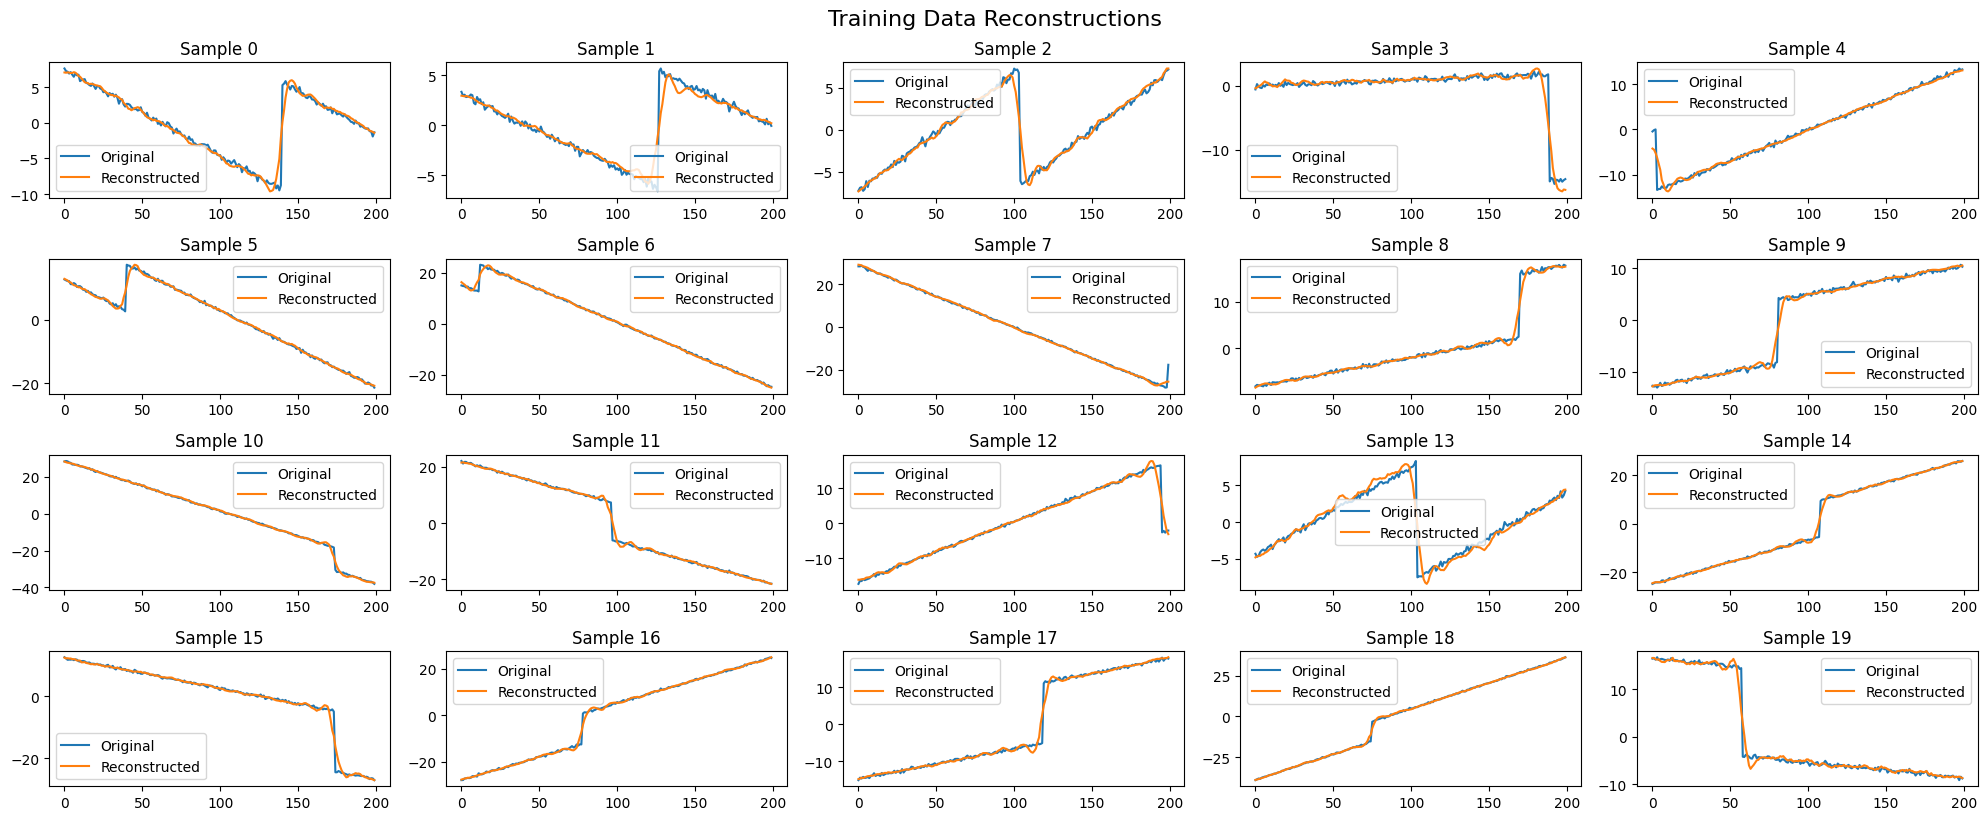

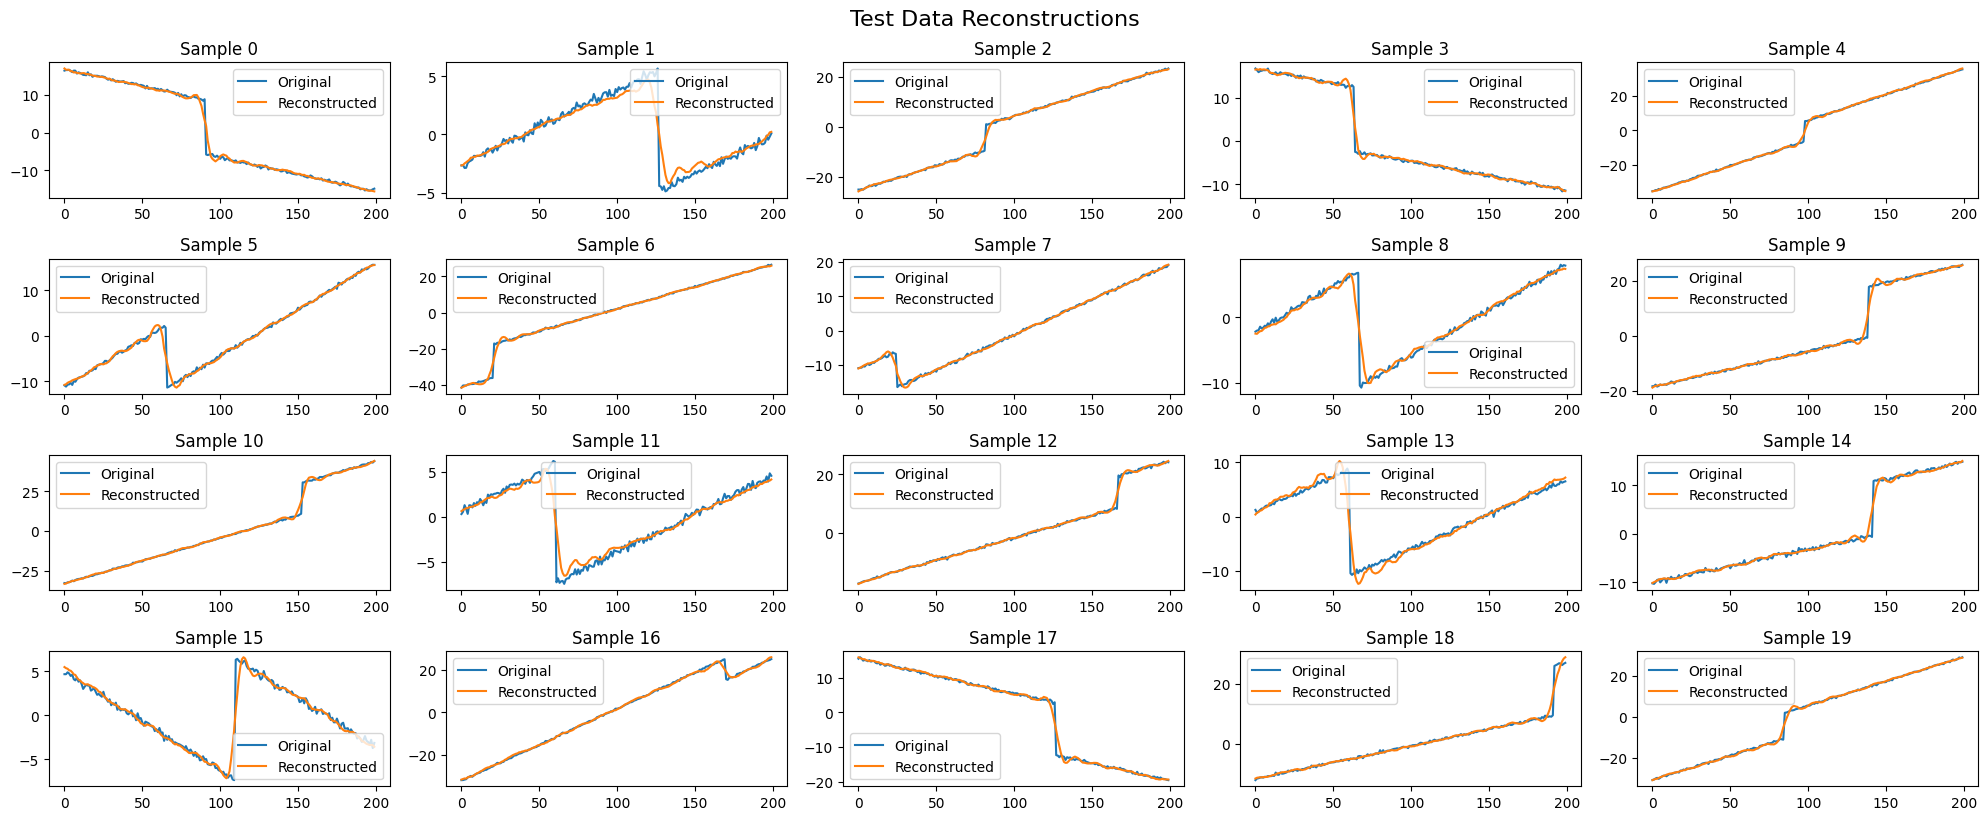

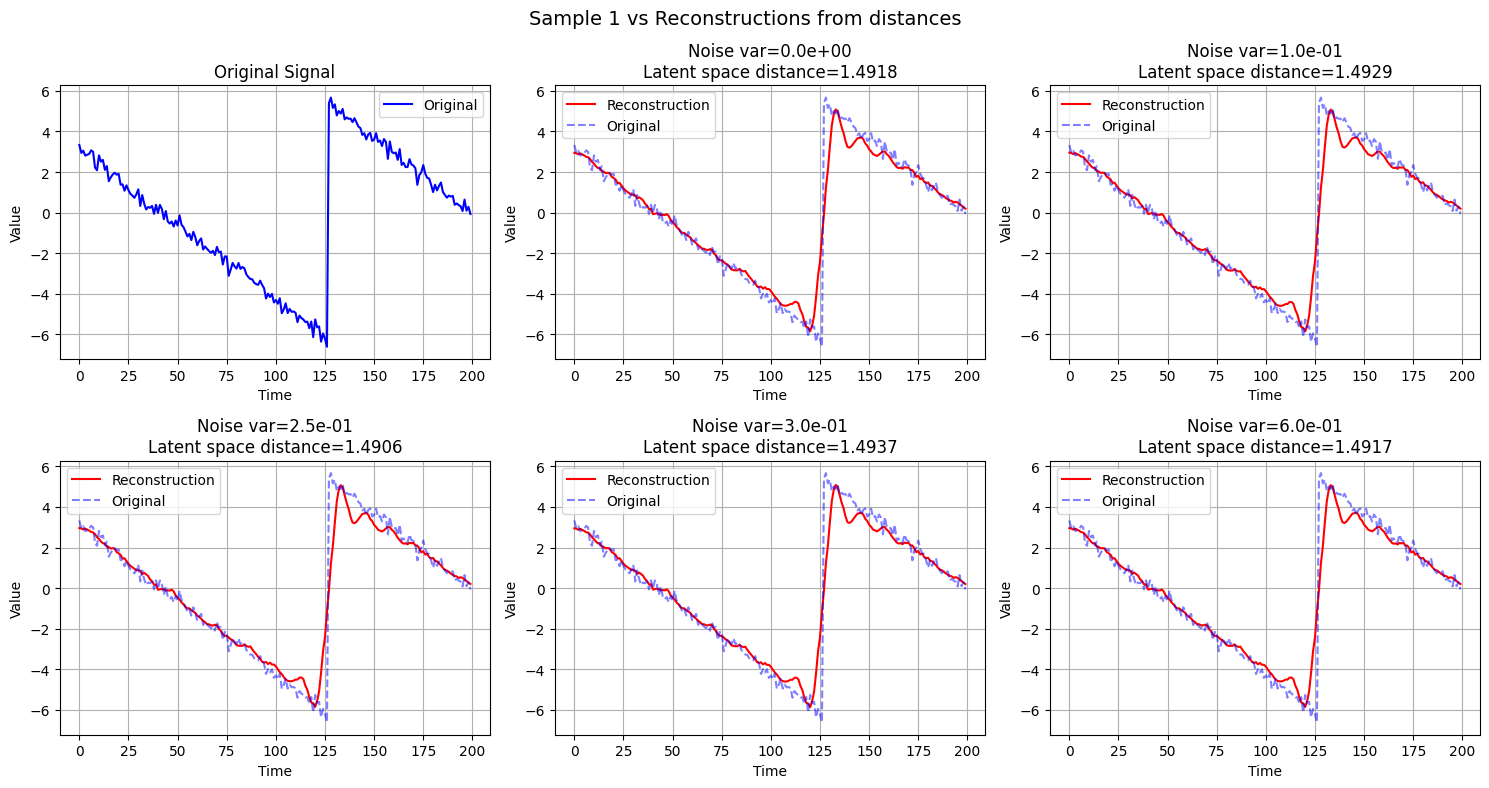

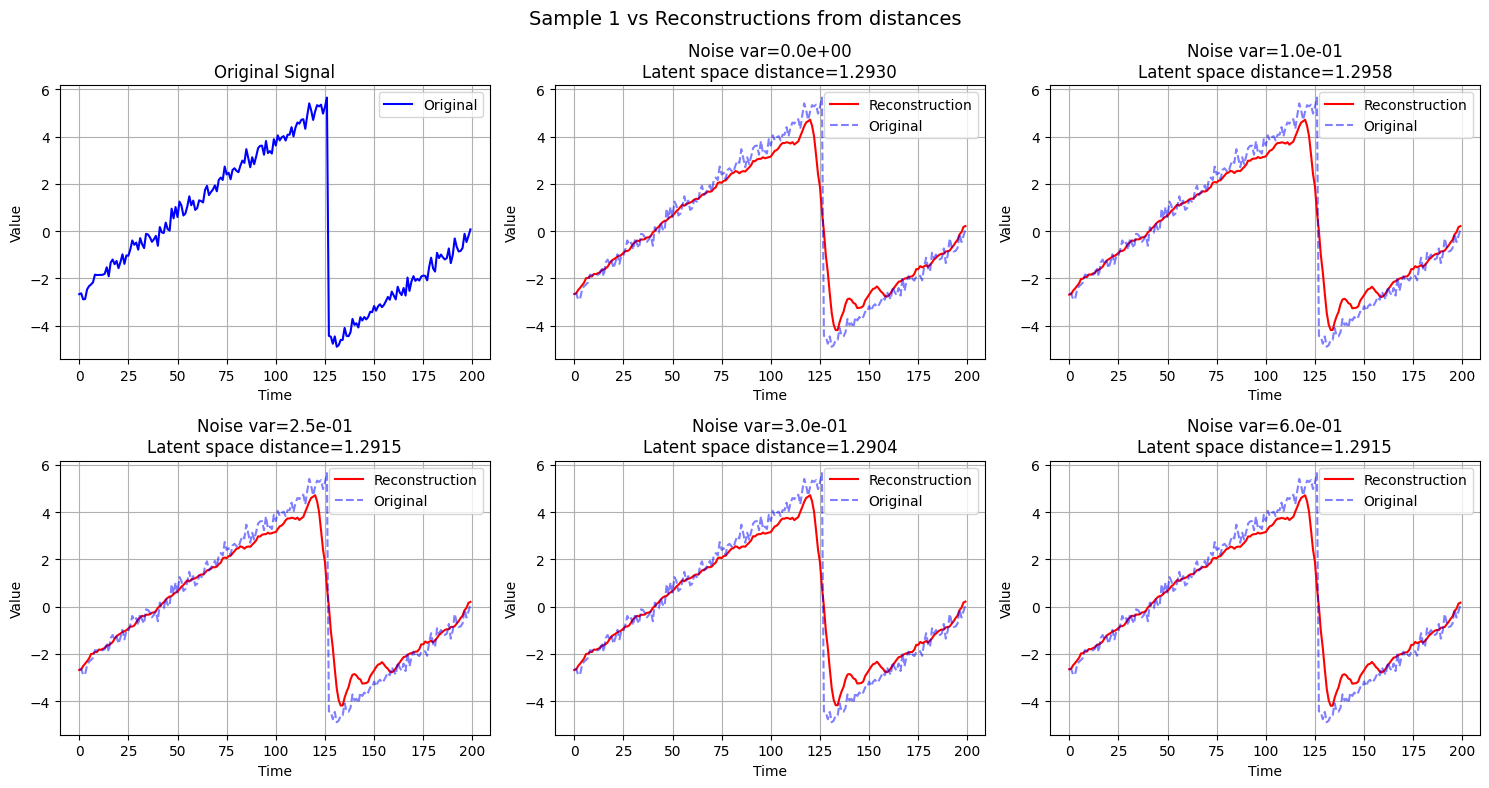

In [5]:
# overwrite = False
with open('run/train.py', 'r') as file:
    exec(file.read())


# Diagnose

In [6]:
# pairwise_distances, ts2tx_distances = net_emb(df_train, model, config_dict)
# for i in range(95, 105):
#     print(ts2tx_distances['simi']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['simi']['Low amount of consecutive increases.'][i])
    
# for i in range(95, 105):
#     print(ts2tx_distances['l2']['High amount of consecutive increases.'][i])
#     print(ts2tx_distances['l2']['Low amount of consecutive increases.'][i])

# Generation

0    The time series exhibits a downward linear trend.
Name: segment1, dtype: object


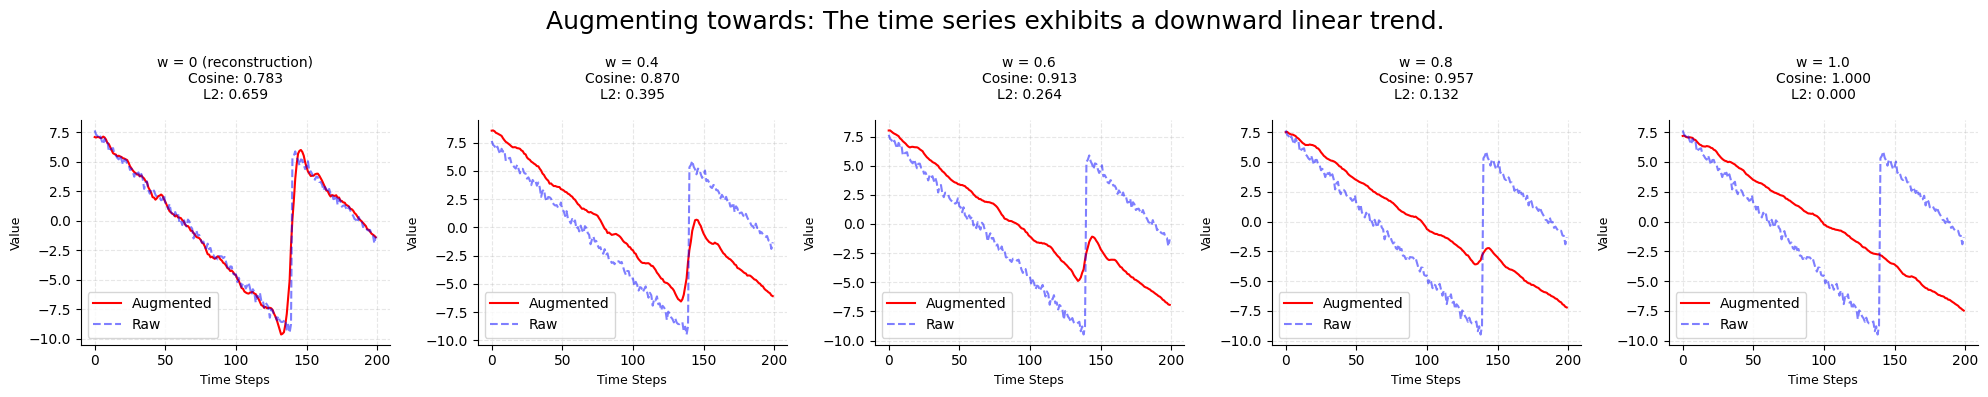

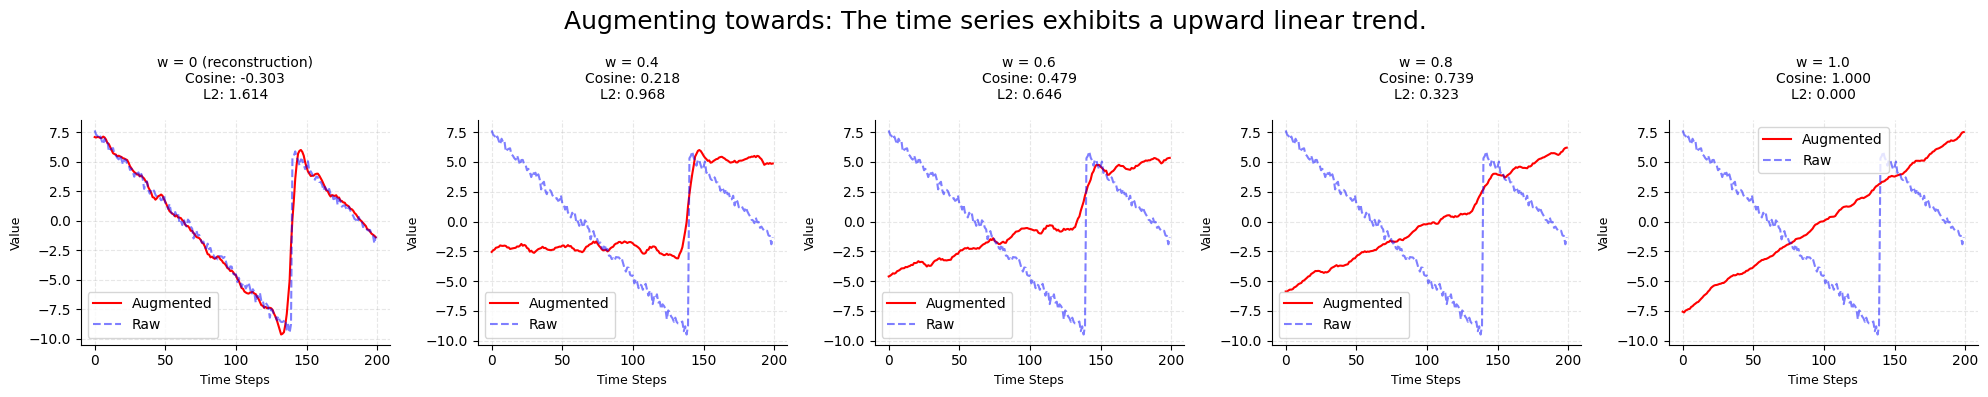

0    The time series exhibits a upward linear trend.
Name: segment1, dtype: object


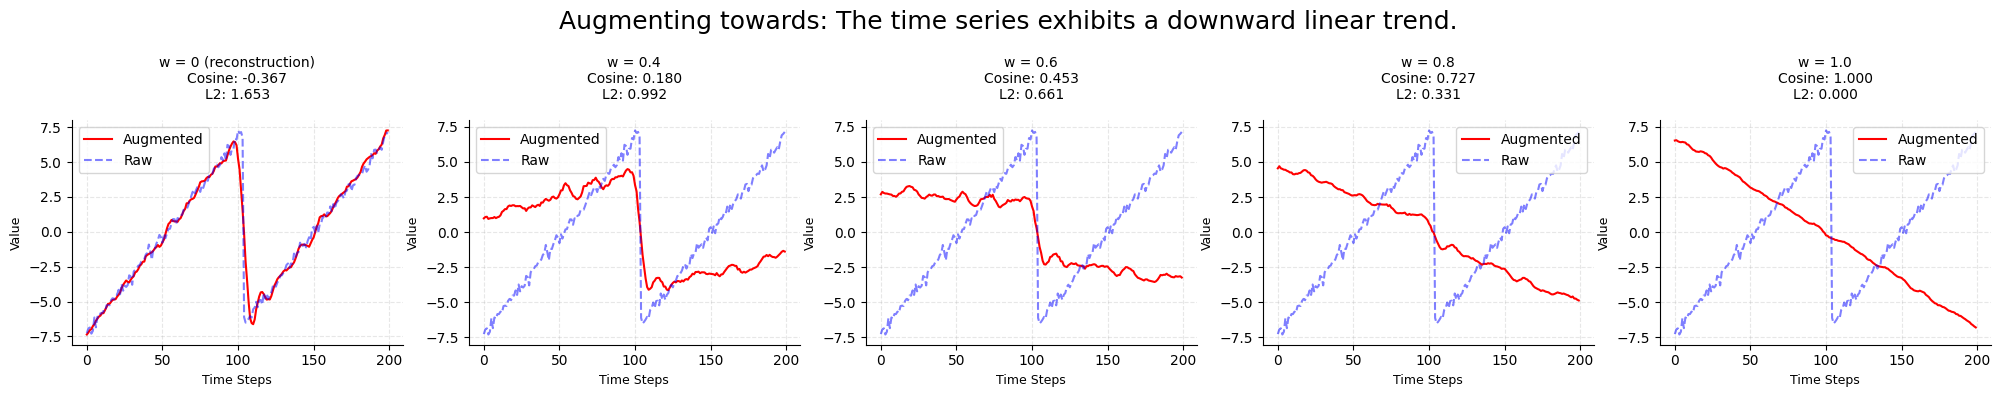

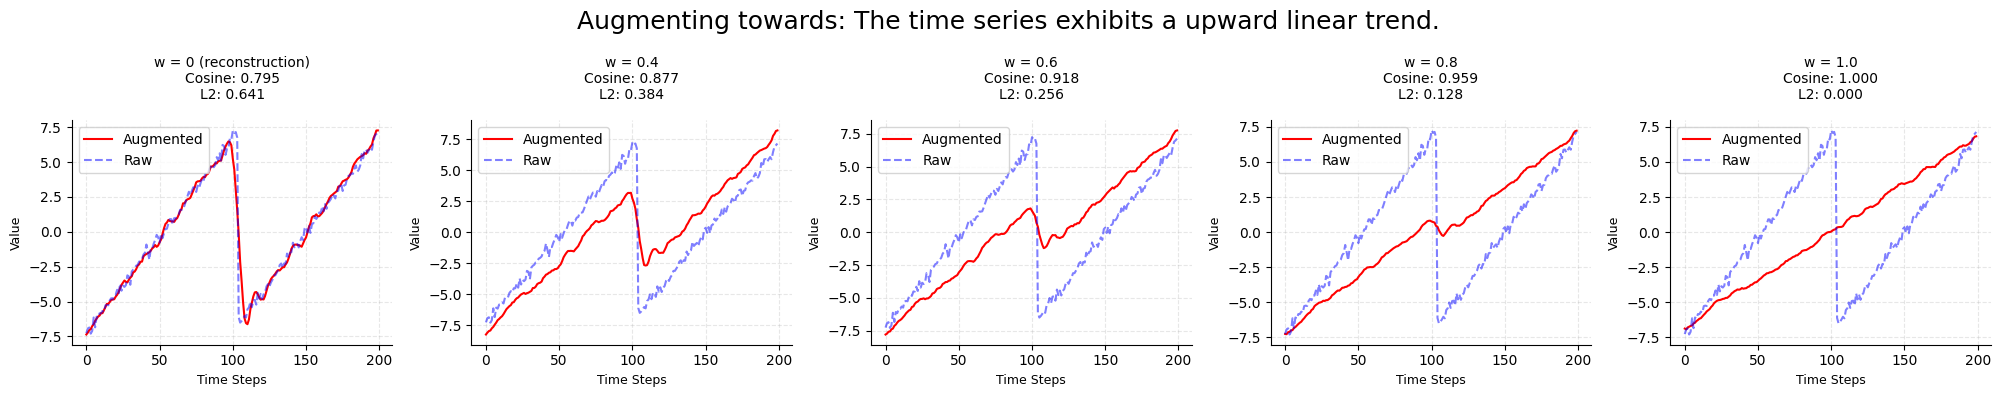

0    The mean of the time series shifts over time.
Name: segment2, dtype: object


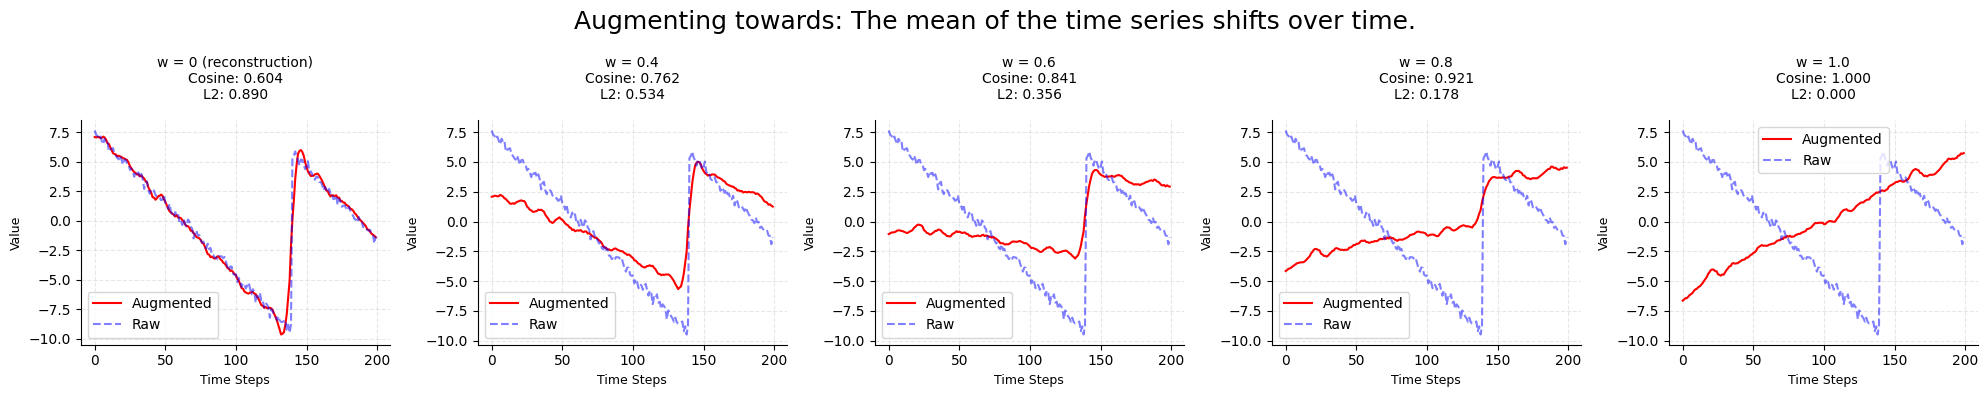

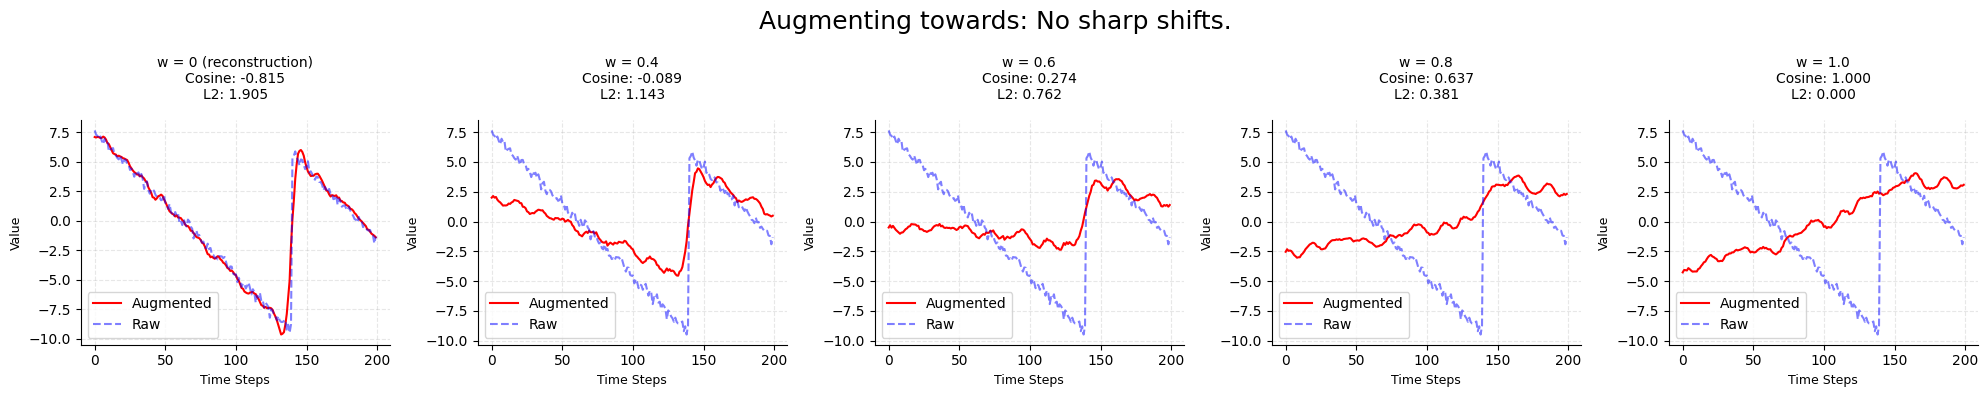

0    No sharp shifts.
Name: segment2, dtype: object


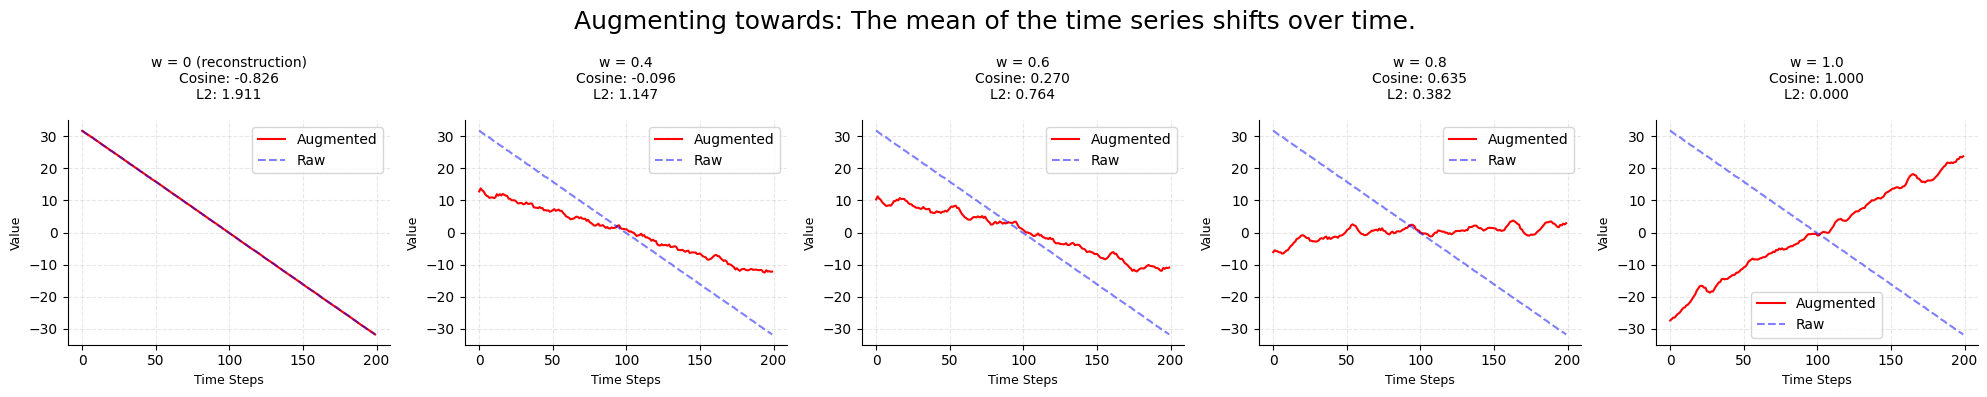

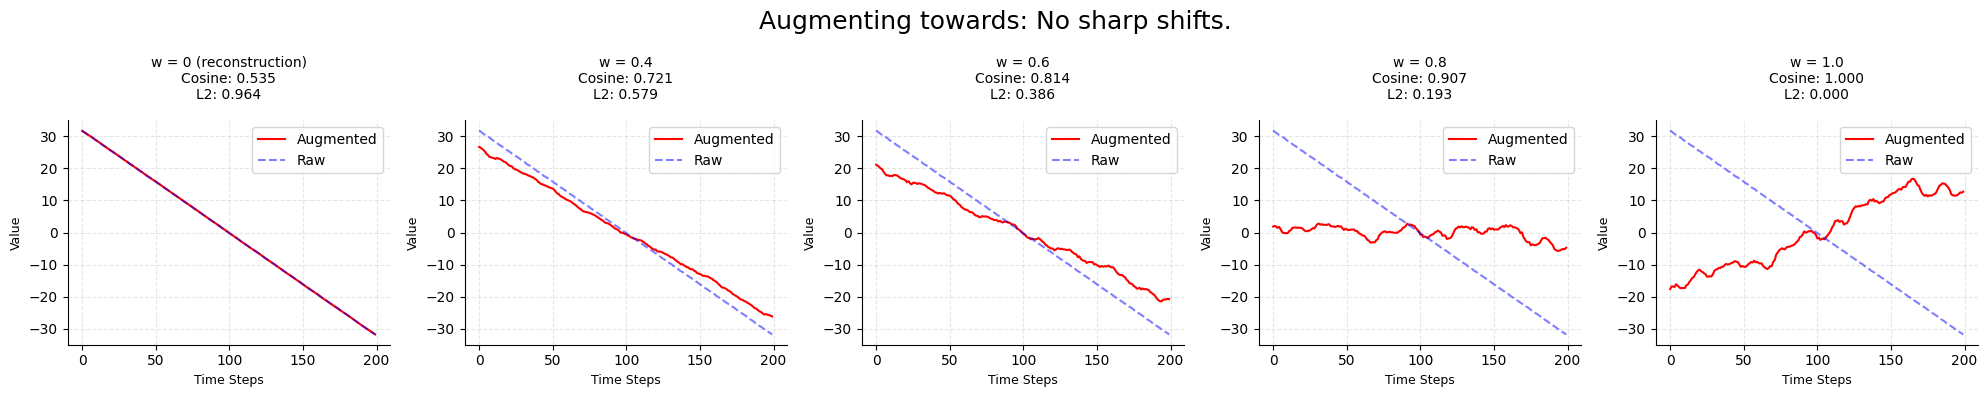

In [7]:
tid = 0

y_levels = config_dict['y_levels']
y_col = config_dict['y_col']

for y_col in [col for col in config_dict['custom_target_cols'] if col != 'label']:
    y_levels = list(df_train[y_col].unique())
    df_train_ls = []
    df_test_ls = []
    for i in range(len(y_levels)):
        df_train_ls.append(df_train[df_train[y_col] == y_levels[i]].reset_index(drop=True))
        df_test_ls.append(df_test[df_test[y_col] == y_levels[i]].reset_index(drop=True))


    for i in range(len(y_levels)):
        df = df_train_ls[i].iloc[[tid]].copy()
        print(df[y_col])
        for j in range(len(y_levels)):
            df['text' + str(j)] = y_levels[j]
        text_cols = ['text' + str(j) for j in range(len(y_levels))]
        w_values = np.arange(0.4, 1.2, 0.2)
        w_values = np.concatenate([[0], w_values])
        plot_interpolate_ts_tx_ws(df, model, config_dict, text_cols, w_values = w_values, label = True)


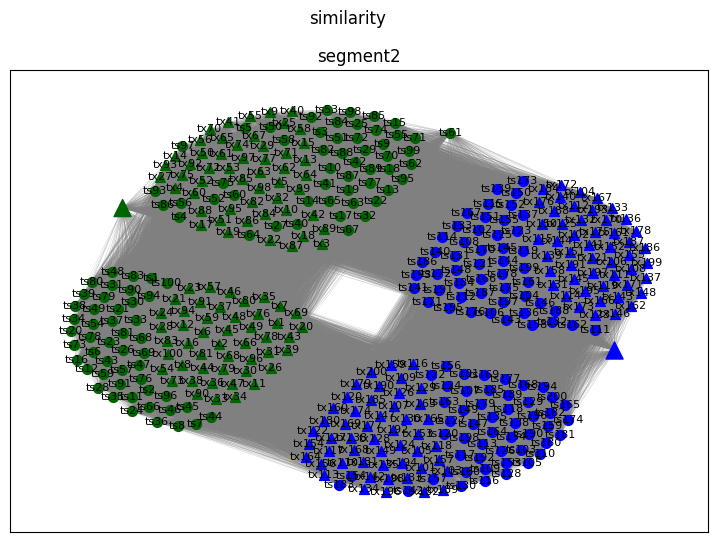

In [8]:
# pairwise_distances = net_emb_w_text(df_train, model, config_dict)

df = df_train
top = 100
y_col = None
text_levels = None

# network the ts and text embeddings with predicted text conditions
if y_col is None:
    y_col = config_dict['y_col']
if text_levels is None:
    text_levels = config_dict['y_levels']

df_ls = []
for i in range(len(text_levels)):
    df_sub = df[df[y_col].str.contains(text_levels[i], case=False, na=False)].reset_index(drop=True) # if text_levels[i] is a substring of each row df[y_col]
    df_sub = df_sub.iloc[range(top)].copy()
    df_ls.append(df_sub)
df = pd.concat(df_ls, ignore_index=True)

text_cols = []
for i in range(len(text_levels)):
    df['text'+str(i)] = text_levels[i]
    text_cols.append('text'+str(i))

pairwise_distances = cal_embeddings_distances_w_text(df, text_cols, model, config_dict)

adj_mat = pairwise_distances['simi'].detach().cpu().numpy()
plot_embeddings_graph_w_text(adj_mat, k=len(text_levels), title = y_col, subtitle = 'similarity')



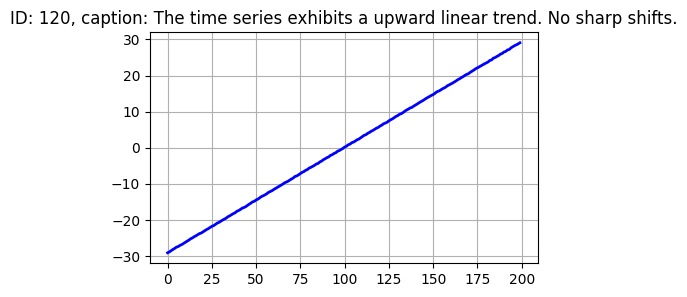

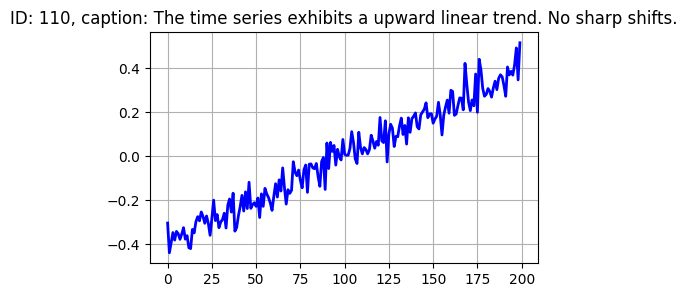

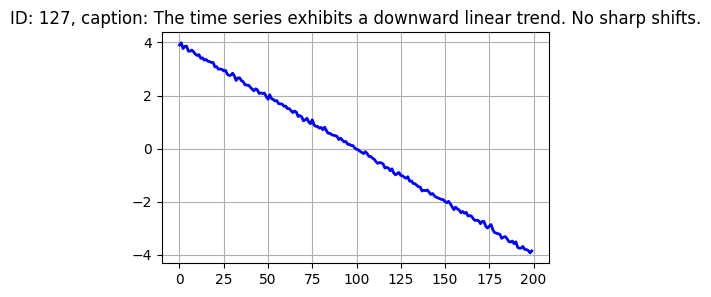

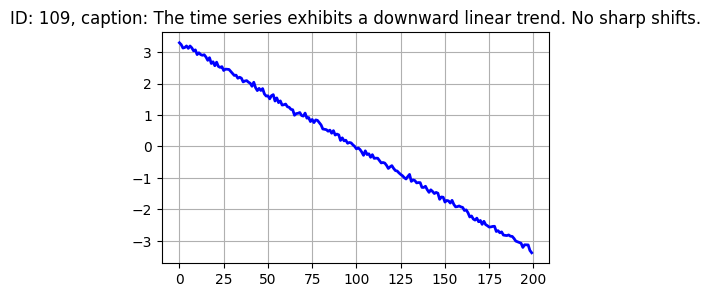

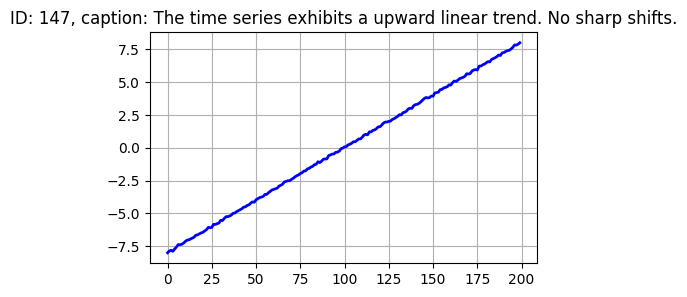

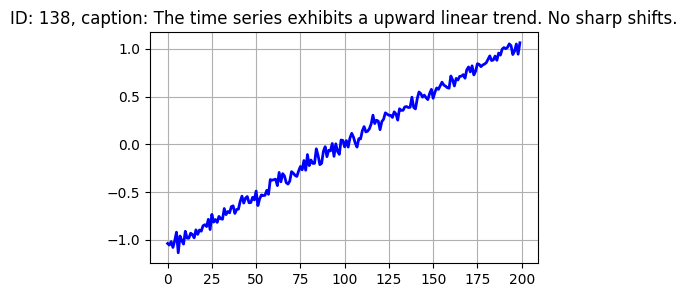

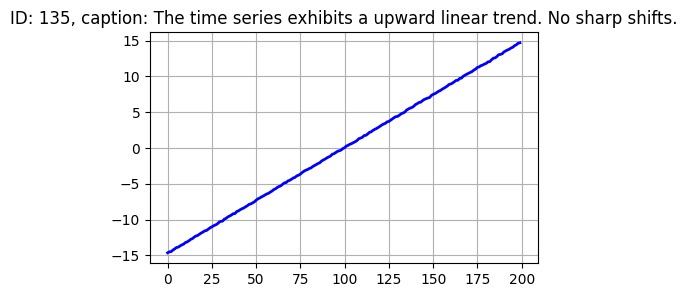

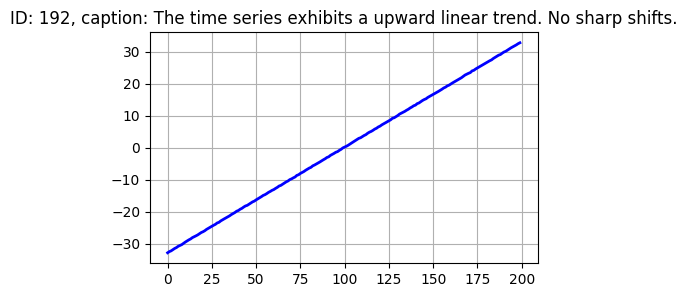

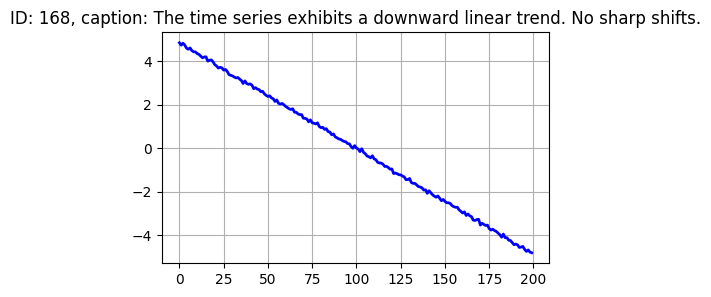

In [9]:

for tid in [120,110, 127, 109, 147, 138, 135, 192, 168]:
    plot_ts(df, tid, 200)

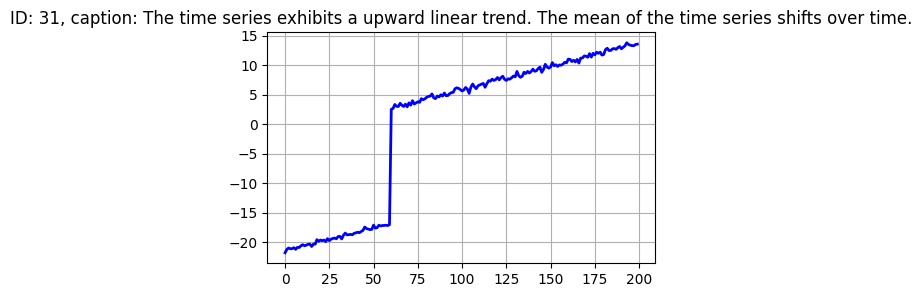

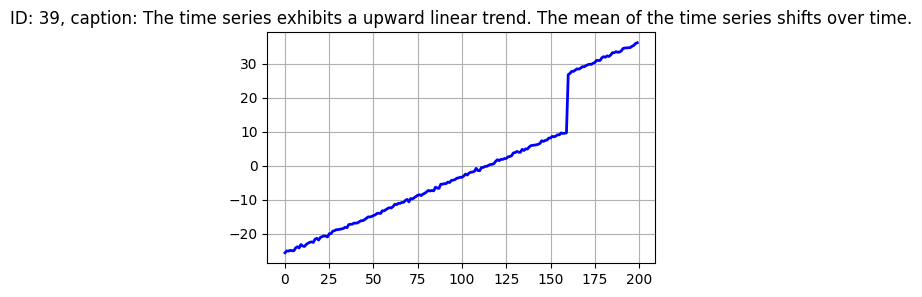

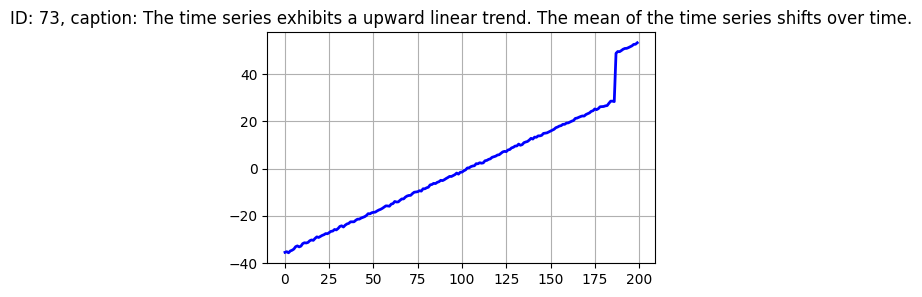

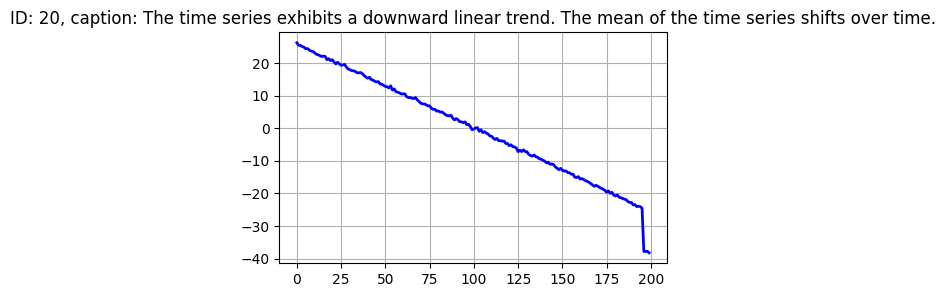

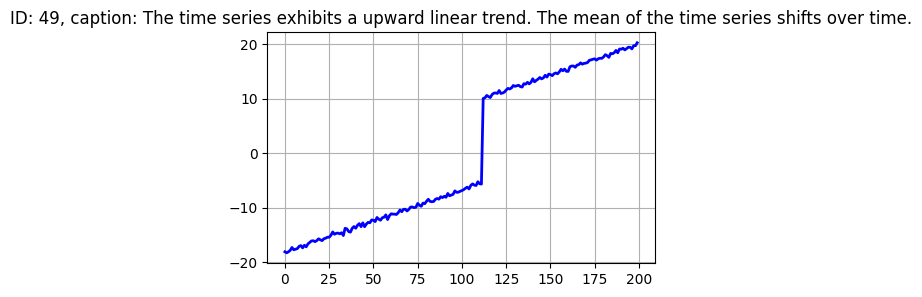

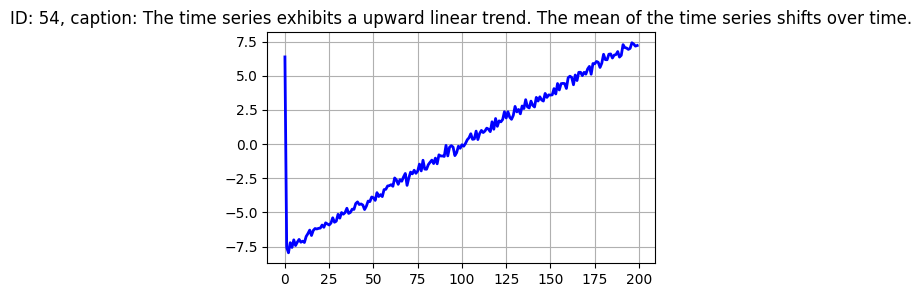

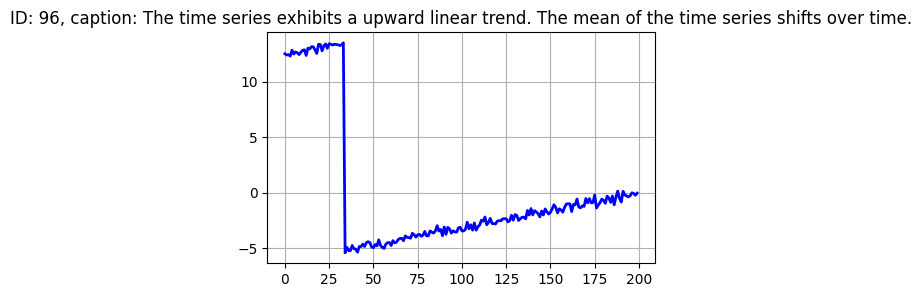

In [10]:
    
for tid in [31,39,73,20,49,54,96]:
    plot_ts(df, tid, 200)

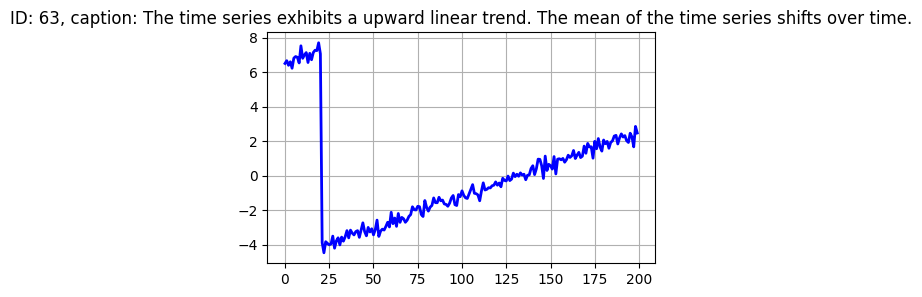

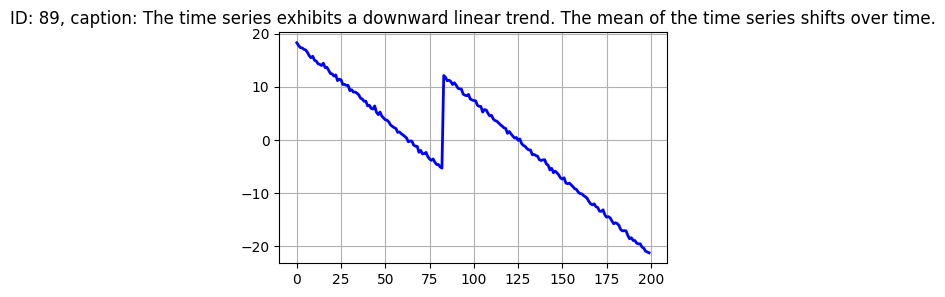

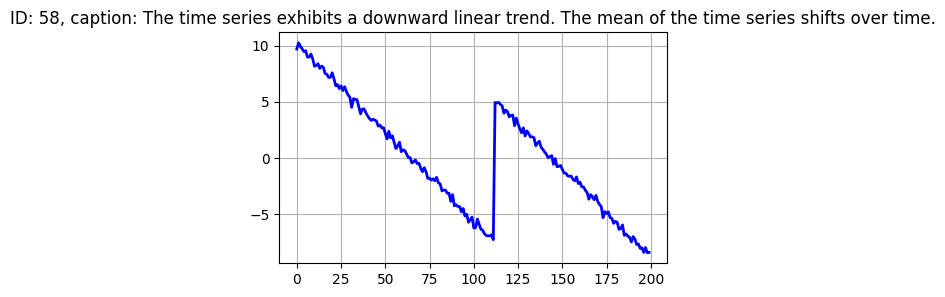

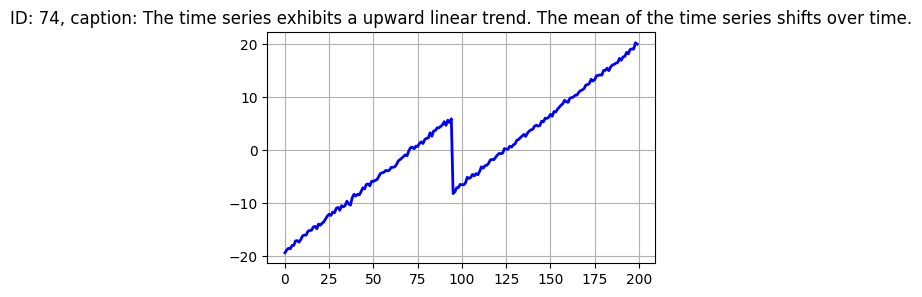

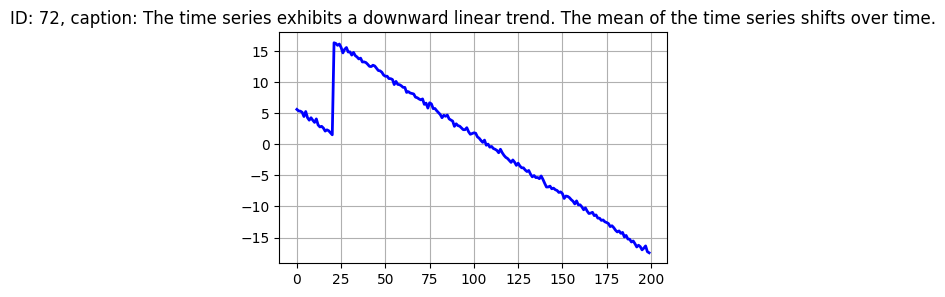

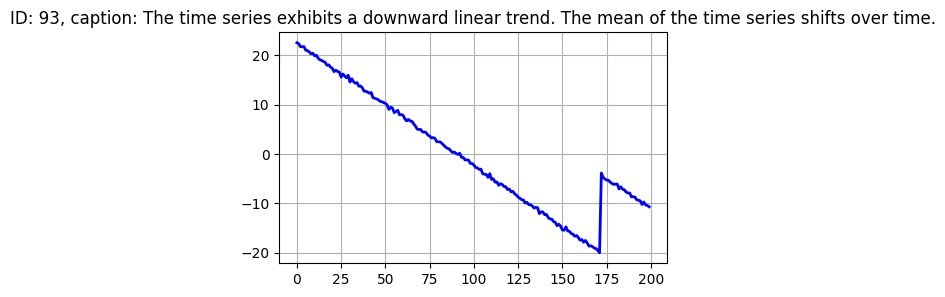

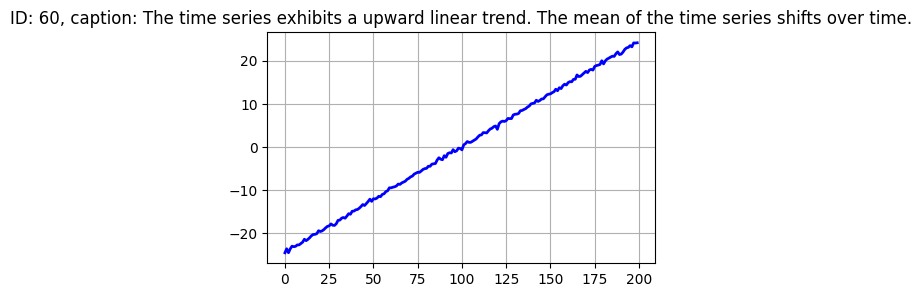

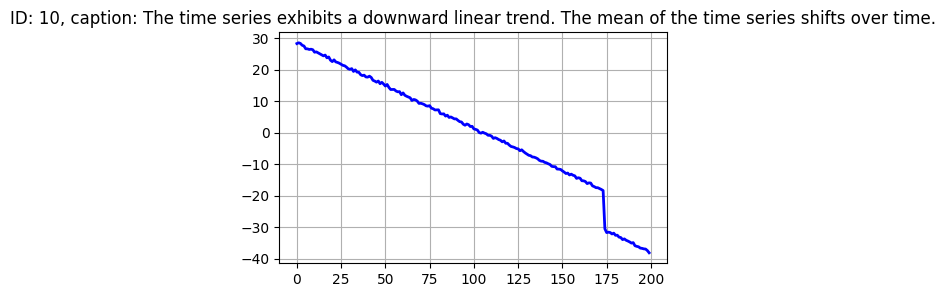

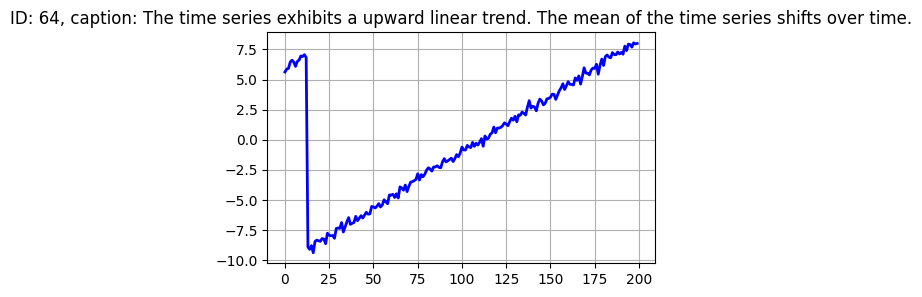

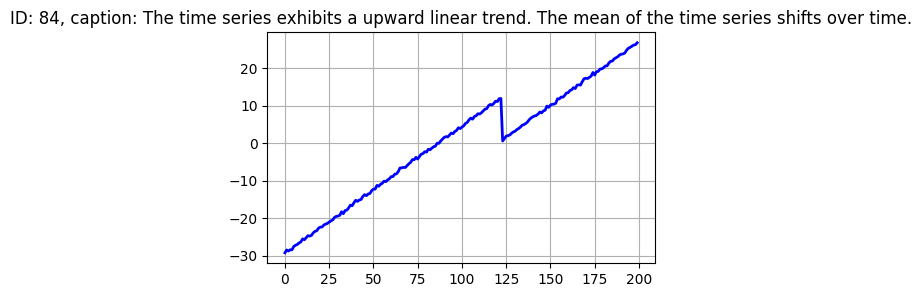

In [11]:
for tid in [63, 89, 58, 74, 72,93,60,10,64,84]:
    plot_ts(df, tid, 200)


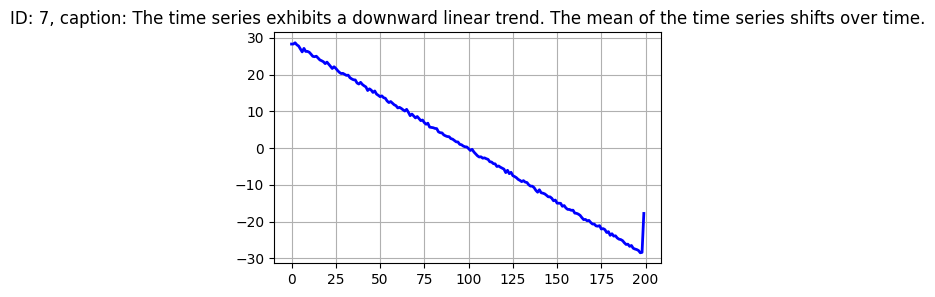

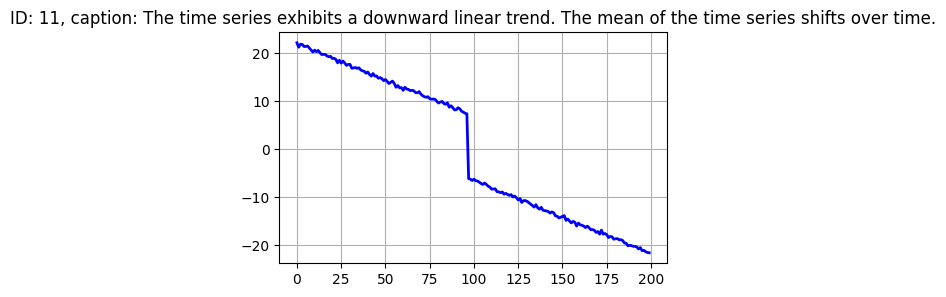

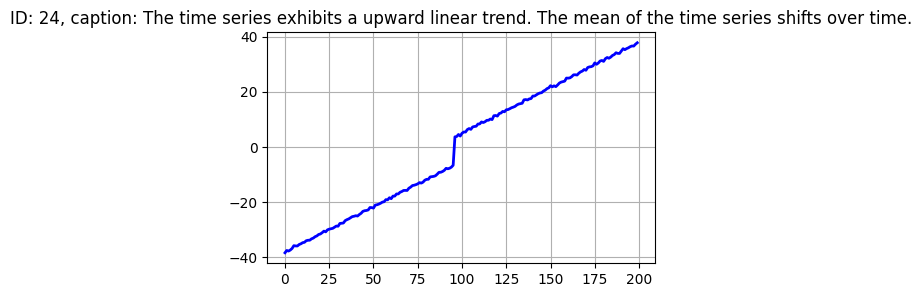

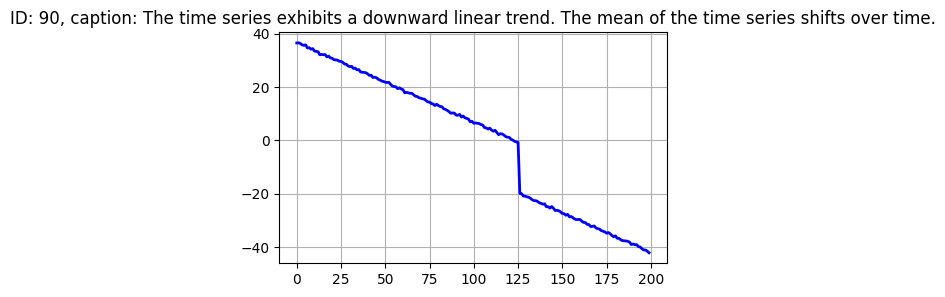

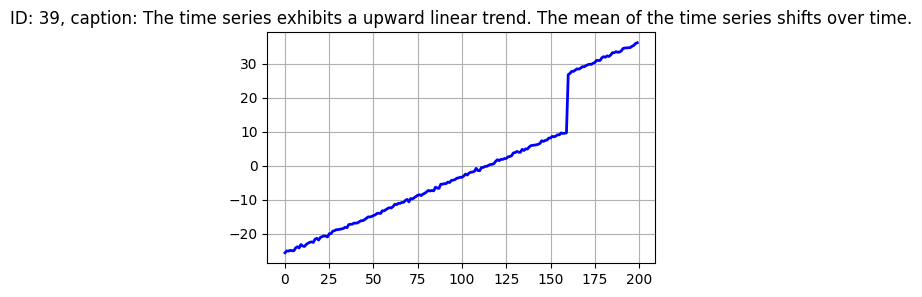

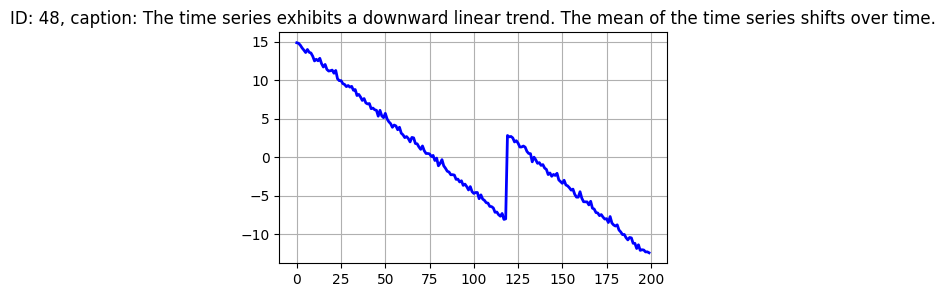

In [12]:
for tid in [7, 11, 24, 90, 39, 48]:
    plot_ts(df, tid, 200)
    

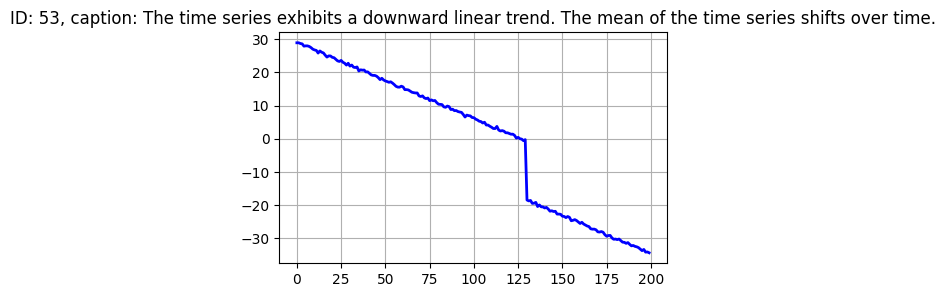

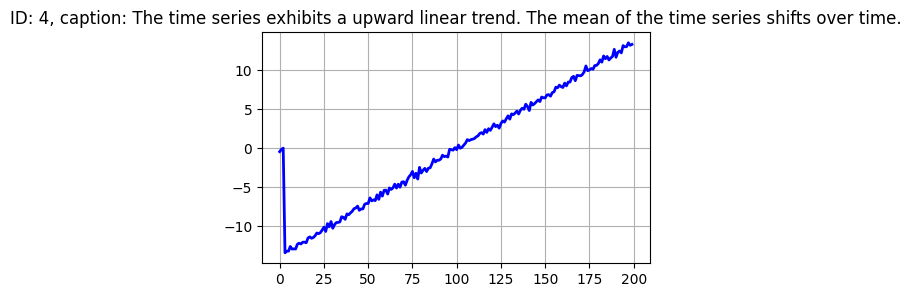

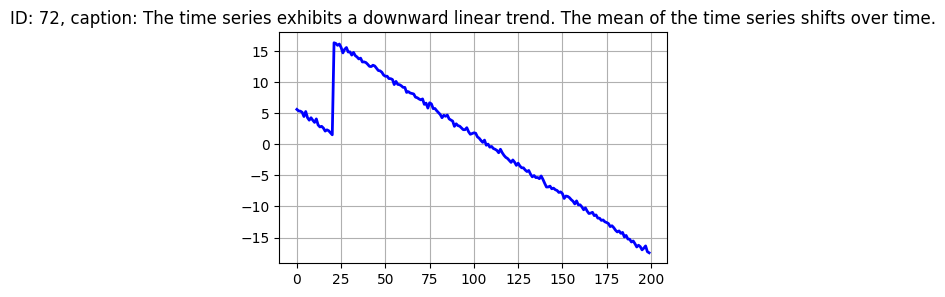

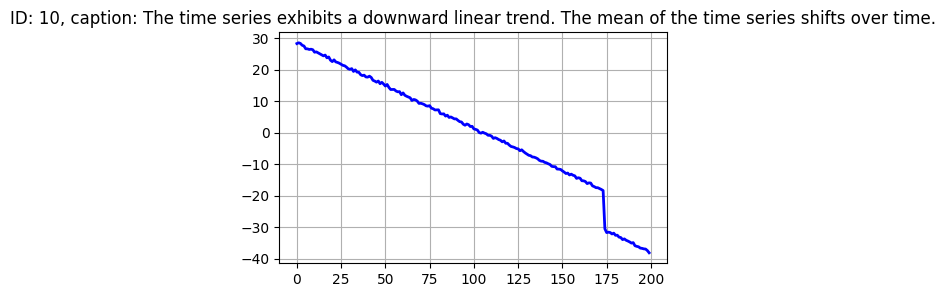

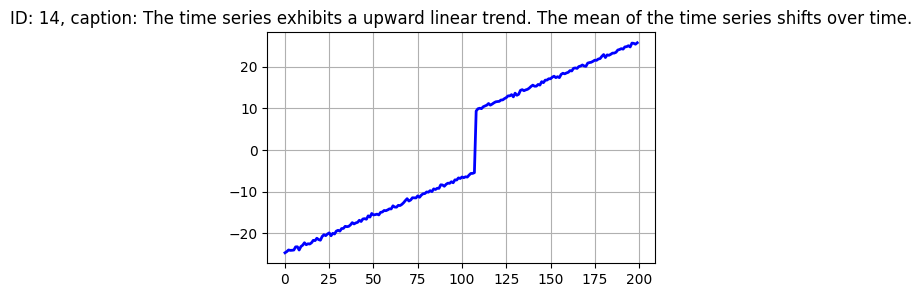

In [13]:

for tid in [53, 4, 72, 10, 14]:
    plot_ts(df, tid, 200)
